In [1]:
# Import necessary modules
import os
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from pathlib import Path
from tabulate import tabulate
import glob
from datetime import datetime
from numpy.linalg import solve
import shutil
from matplotlib.colors import Normalize


In [2]:
# Initialize global path variables (None by default)
DISPLACEMENT_PATH = None
LOADING_PATH = None
STIFFNESS_PATH = None
MASS_PATH = None

def get_directory_info():
    """
    Gather and display comprehensive information about the working directories and results files.
    Returns a dictionary containing all the collected information.
    """
    # Get current timestamp for the report
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Initialize info dictionary to store directory and file information
    dir_info = {
        'timestamp': current_time,
        'paths': {},  # Stores paths and their existence status
        'file_counts': {},  # Stores the number of files in each directory
        'file_examples': {}  # Stores examples of files in each directory
    }

    # Print report header
    print("\n" + "="*60)
    print(f"DIRECTORY AND FILE INFORMATION REPORT".center(60))
    print(f"Generated on: {current_time}".center(60))
    print("="*60 + "\n")

    # Get and display the parent directory (assumes parent directory contains result folders)
    parent_path = os.getcwd()
    print("[SYSTEM PATHS]")
    print(f"• Parent directory: {parent_path}\n")

    # Define all result paths relative to the parent directory
    global DISPLACEMENT_PATH, LOADING_PATH, STIFFNESS_PATH, MASS_PATH
    result_paths = {
        'Displacement': os.path.join(parent_path, "Kratos_Results", "displacement_results"),
        'Loading': os.path.join(parent_path, "Kratos_Results", "loading_results"),
        'Stiffness': os.path.join(parent_path, "Kratos_Results", "stiffness_results"),
        'Mass': os.path.join(parent_path, "Kratos_Results", "mass_results")
    }

    # Save the folder addresses into global variables
    DISPLACEMENT_PATH = result_paths['Displacement']
    LOADING_PATH = result_paths['Loading']
    STIFFNESS_PATH = result_paths['Stiffness']
    MASS_PATH = result_paths['Mass']

    # Check and display each path's existence and file details
    print("[RESULT DIRECTORIES]")
    for name, path in result_paths.items():
        exists = os.path.exists(path)  # Check if the directory exists
        dir_info['paths'][name] = {
            'path': path,
            'exists': exists
        }
        
        # Display the status of the directory
        status = "✓ FOUND" if exists else "✗ NOT FOUND"
        print(f"• {name.ljust(12)}: {status.ljust(12)} {path}")
        
        if exists:
            # List non-hidden files in the directory
            files = [f for f in os.listdir(path) if not f.startswith('.')]
            file_count = len(files)
            dir_info['file_counts'][name] = file_count
            dir_info['file_examples'][name] = files[:3]  # Store first 3 files as examples
            
            # Display file count and examples
            print(f"  {' ' * 12}  Contains {file_count} files")
        else:
            # If directory does not exist, set file count and examples to 0 and empty list
            dir_info['file_counts'][name] = 0
            dir_info['file_examples'][name] = []
    
    # Display summary of the results
    print("\n[SUMMARY]")
    total_files = sum(dir_info['file_counts'].values())  # Total number of files across all directories
    existing_dirs = sum(1 for path in dir_info['paths'].values() if path['exists'])  # Count of existing directories
    
    print(f"• Found {existing_dirs}/4 result directories")
    print(f"• Total files across all directories: {total_files}")
    
    # Identify the directory with the most files
    if total_files > 0:
        latest_dir = max(
            ((name, path['path']) for name, path in dir_info['paths'].items() if path['exists']),
            key=lambda x: dir_info['file_counts'][x[0]],  # Find directory with most files
            default=("None", "")
        )
        print(f"• Directory with most files: {latest_dir[0]} ({dir_info['file_counts'][latest_dir[0]]} files)")
    
    # Print footer with a helpful tip
    print("\n" + "="*60)
    print("TIP: Ensure all expected result directories exist in the Kratos_Results folder.")
    print("="*60 + "\n")
    
    # Return the collected directory and file information
    return dir_info

# Example usage
if __name__ == "__main__":
    # Generate and display directory information
    directory_info = get_directory_info()



           DIRECTORY AND FILE INFORMATION REPORT            
             Generated on: 2025-04-02 13:48:27              

[SYSTEM PATHS]
• Parent directory: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading

[RESULT DIRECTORIES]
• Displacement: ✓ FOUND      d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\displacement_results
                Contains 10 files
• Loading     : ✓ FOUND      d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\loading_results
                Contains 10 files
• Stiffness   : ✓ FOUND      d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\stiffness_results
                Contains 10 files
• Mass        : ✓ FOUND      d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\mass_results
                Contains 10 files

[SUMMARY]
• Found 4/4 result directories
• Total files across all directories: 40
• Directory with most files: Displacement (10 files)

TIP: Ensure all expected result directories exist in


Selected displacement file: displacements_modulus_[-127.38, 115.42, 208.84].npy
Initial displacement data shape: (1, 63, 3)
Processed displacement shape: (63, 3)

Mesh Information:
Number of nodes: 63
Number of elements: 80
Displacement data shape: (63, 3)


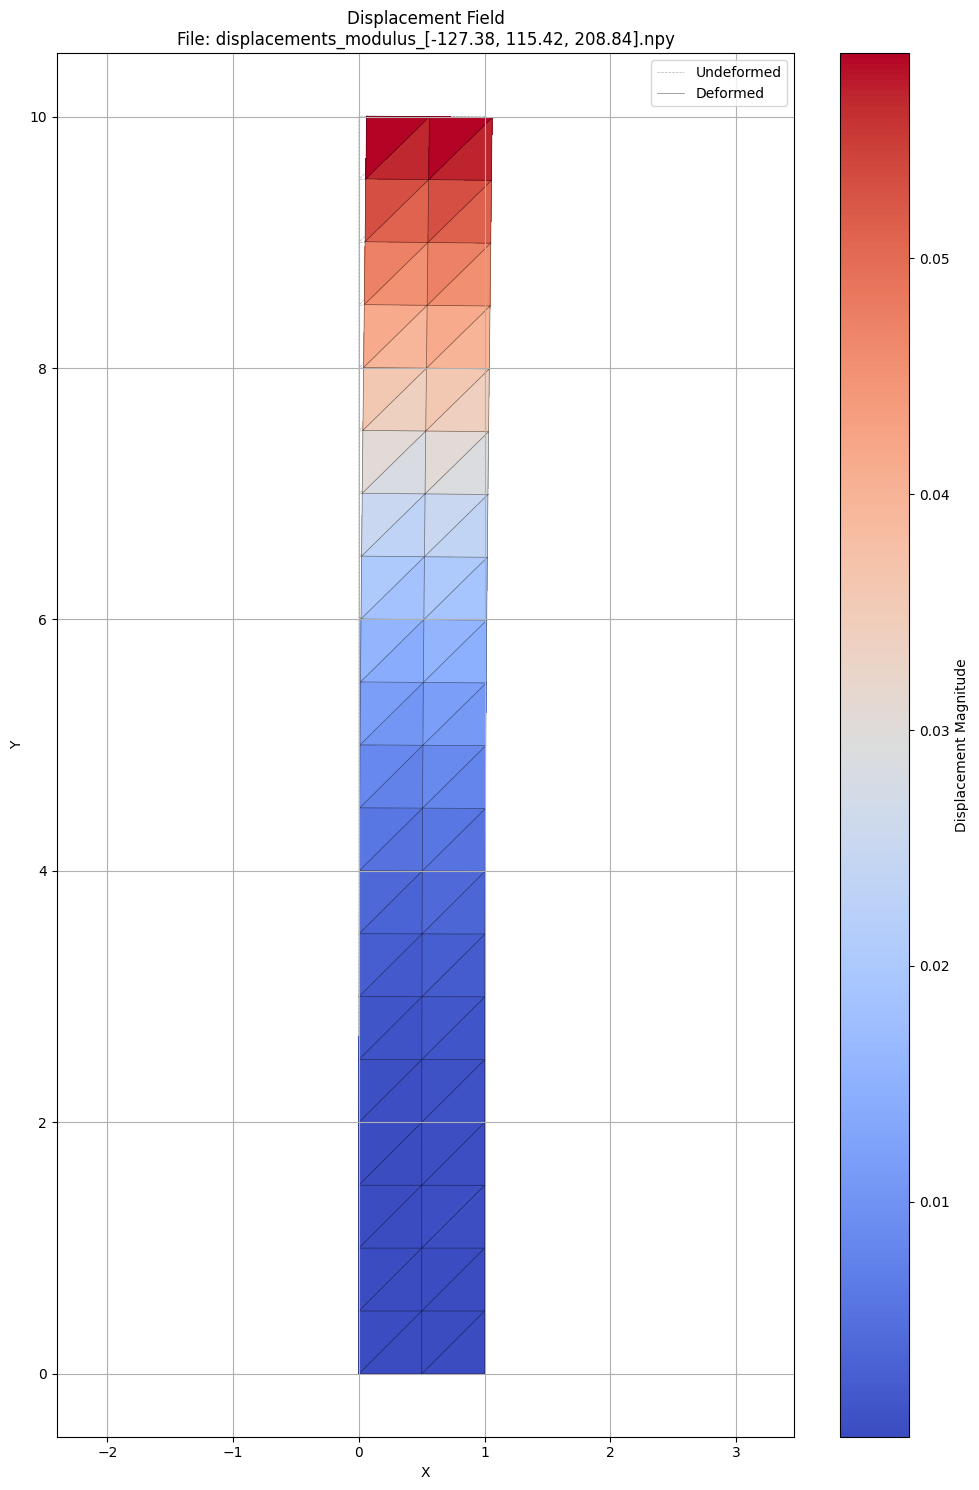


Displacement Statistics:
Scaling factor used: 2.0e+05
Maximum displacement magnitude: 6.09e-02
Minimum displacement magnitude: 0.00e+00
Mean displacement magnitude: 1.83e-02


In [3]:
# Function to plot displacement field for a single time step
# with improved error handling and debugging information
def plot_displacement_timestep(x_data, time_step, mdpa_file, random_displacement_file, scale_factor=1e7):
    """
    Plot displacement field for a single time step with improved error handling.
    
    Parameters:
    -----------
    x_data: ndarray of shape (num_nodes, 3) displacement data (x,y,z for each node)
    time_step: int, which time step to plot (not used here but kept for compatibility)
    mdpa_file: str, path to mdpa file (mesh data file)
    scale_factor: float, scaling factor for displacements
    """
    try:
        # Initialize empty lists to store node coordinates and element connectivity
        node_coords = []
        elements = []
        
        # Flags to control when we are reading nodes and elements sections of the file
        reading_nodes = False
        reading_elements = False
        
        # Open and read the mdpa file
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()  # Remove any extra spaces from each line
                
                # If the line indicates the start of node section, start reading nodes
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                # If the line indicates the end of node section, stop reading nodes
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                # If we are reading nodes and the line contains data, process it
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        # Extract x and y coordinates from the line (assuming 2D mesh)
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])  # Store the coordinates in the list
                        
                # If the line indicates the start of element section, start reading elements
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                # If the line indicates the end of element section, stop reading elements
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                # If we are reading elements and the line contains data, process it
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        # Get element node indices (adjust for 0-based indexing)
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])  # Store the element node indices
        
        # Convert node coordinates and elements lists into numpy arrays for easier handling
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # Debugging information to print the mesh details
        print(f"\nMesh Information:")
        print(f"Number of nodes: {len(node_coords)}")
        print(f"Number of elements: {len(elements)}")
        print(f"Displacement data shape: {x_data.shape}")
        
        # Check if the displacement data matches the number of nodes (for compatibility)
        if len(node_coords) != len(x_data):
            raise ValueError(f"Mismatch between nodes ({len(node_coords)}) and displacements ({len(x_data)})")
        
        # Get only the x and y displacement components (assuming 2D analysis)
        displacements = x_data[:, :2] * scale_factor  # Scale displacements for better visualization
        disp_mag = np.sqrt(displacements[:, 0]**2 + displacements[:, 1]**2)  # Magnitude of displacement
        
        # Calculate the new coordinates for the deformed mesh based on displacements
        deformed_coords = node_coords + displacements
        
        # Create a plot with a specific size
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create triangulations for the original and deformed meshes
        triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
        
        # Plot the undeformed mesh as a dashed line with low opacity
        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
        
        # Plot the deformed mesh with displacement magnitudes colored
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm')
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
        
        # Add a colorbar to show the scale of displacements
        cbar = plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        
        # Set plot labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nFile: {random_displacement_file}')
        ax.grid(True)
        ax.axis('equal')  # Keep axes equal for proper aspect ratio
        ax.legend()  # Add legend to the plot
        
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()  # Display the plot
        
        # Print displacement statistics for debugging or further analysis
        print("\nDisplacement Statistics:")
        print(f"Scaling factor used: {scale_factor:.1e}")
        print(f"Maximum displacement magnitude: {np.max(disp_mag):.2e}")
        print(f"Minimum displacement magnitude: {np.min(disp_mag):.2e}")
        print(f"Mean displacement magnitude: {np.mean(disp_mag):.2e}")
        
    except Exception as e:
        print(f"\nError in plot_displacement_timestep: {str(e)}")
        raise

def execute_displacement_plot(displacement_folder, mdpa_file, scale_factor=2e5):
    """
    Function to execute the displacement plot without storing unnecessary variables.
    
    Parameters:
    -----------
    displacement_folder: str, path to the folder containing displacement files
    mdpa_file: str, path to the .mdpa file
    scale_factor: float, scaling factor for displacements
    """
    try:
        # Find all displacement files (those ending in .npy) in the given folder
        displacement_files = [f for f in os.listdir(displacement_folder) if f.endswith(".npy")]
        
        # Raise an error if no displacement files are found
        if not displacement_files:
            raise FileNotFoundError(f"No displacement files found in folder: {displacement_folder}")
        
        # Randomly select a displacement file from the folder
        random_displacement_file = random.choice(displacement_files)
        random_file_path = os.path.join(displacement_folder, random_displacement_file)
        
        # Load the selected displacement file
        displacements = np.load(random_file_path)
        
        print(f"\nSelected displacement file: {random_displacement_file}")
        print(f"Initial displacement data shape: {displacements.shape}")
        
        # Process the displacement data (ensure correct shape for plotting)
        displacements = np.squeeze(displacements)  # Remove extra dimensions if any
        print(f"Processed displacement shape: {displacements.shape}")
        
        # Call the plot function to visualize the displacement field
        plot_displacement_timestep(
            x_data=displacements,
            time_step=0,
            mdpa_file=mdpa_file,
            random_displacement_file=random_displacement_file,
            scale_factor=scale_factor
        )
    
    except Exception as e:
        print(f"\nError in execute_displacement_plot: {str(e)}")
        import traceback
        traceback.print_exc()

# Execute the function
# Dynamically obtain the .mdpa file path and displacement folder
cwd = os.getcwd()
mdpa_files = [f for f in os.listdir(cwd) if f.endswith(".mdpa")]
if not mdpa_files:
    raise FileNotFoundError(f"No .mdpa file found in the directory: {cwd}")

# Use the first .mdpa file found
mdpa_file = os.path.join(cwd, mdpa_files[0])

# Execute the function with the dynamically obtained mdpa file
execute_displacement_plot(displacement_folder=DISPLACEMENT_PATH, mdpa_file=mdpa_file, scale_factor=2e5)

In [4]:
import re
from pathlib import Path
from tabulate import tabulate

def extract_parameters(filename):
    """
    Extract parameters from filenames in the format '[...]'.
    
    Parameters:
    -----------
    filename : str
        The name of the file from which parameters will be extracted.
    
    Returns:
    --------
    str
        The extracted parameters from the filename (if any), or an empty string if no parameters are found.
    """
    # Use regular expression to find a pattern of parameters enclosed in square brackets
    match = re.search(r"\[([-.\d, ]+)\]", filename)
    return match.group(1) if match else ""  # Return the matched parameters or an empty string

def display_file_table(file_type, files, path):
    """
    Display a formatted table of files with their parameters.
    
    Parameters:
    -----------
    file_type : str
        The type of the files being displayed (e.g., Displacement, Force Vector, etc.)
    files : list
        A list of filenames to be displayed.
    path : str
        The path to the directory containing the files.
    """
    if not files:
        # If no files are found, notify the user
        print(f"\nNo {file_type} files found in: {path}")
        return
    
    table_data = []  # Initialize an empty list to store table rows
    for i, filename in enumerate(files, 1):  # Loop through each file in the list
        file_path = Path(path) / filename  # Construct the full file path
        table_data.append([  # Add a row to the table data
            i,  # Index number
            filename,  # File name
            extract_parameters(filename) or "N/A",  # Extract parameters from filename, or "N/A" if none
            f"{file_path.stat().st_size / 1024:.1f} KB",  # File size in KB
            Path(path).name  # Directory name (last part of the path)
        ])
    
    # Display the table using the 'tabulate' library
    print(f"\n{file_type.upper()} FILES ({len(files)} found)")
    print(tabulate(table_data,
                 headers=["#", "Filename", "Parameters", "Size", "Directory"],
                 tablefmt="grid",
                 stralign="left",
                 numalign="center"))
    
    # Display parameter range if there is more than one file
    if len(files) > 1:
        print(f"\nParameter range: {extract_parameters(files[0])} to {extract_parameters(files[-1])}")
    else:
        print(f"\nParameters: {extract_parameters(files[0])}")

def analyze_result_files():
    """
    Analyze and display all result files using the existing path variables.
    This function will process and display information about displacement, force vector, stiffness matrix, and mass matrix files.
    """
    print("\n" + "="*60)
    print(" KRATOS SIMULATION FILES ANALYSIS ".center(60))
    print("="*60)
    
    # Function to ensure paths are Path objects (for compatibility)
    def ensure_path(p):
        return Path(p) if isinstance(p, str) else p
    
    # Define the sets of files to process, with their respective directory paths and file name prefixes
    filesets = [
        ("Displacement", ensure_path(DISPLACEMENT_PATH), "displacements_modulus_"),
        ("Force Vector", ensure_path(LOADING_PATH), "global_force_vector_"),
        ("Stiffness Matrix", ensure_path(STIFFNESS_PATH), "stiffness_matrix_"),
        ("Mass Matrix", ensure_path(MASS_PATH), "mass_matrix_")
    ]
    
    # Loop through each file set (Displacement, Force Vector, etc.)
    for name, path, prefix in filesets:
        if path and path.exists():  # Check if the path exists
            try:
                # Get all files in the directory that match the prefix and end with '.npy'
                files = sorted(
                    [f.name for f in path.glob(f"{prefix}*.npy")],  # Get the filenames
                    key=extract_parameters  # Sort files by extracted parameters
                )
                # Display the file table with the extracted data
                display_file_table(name, files, path)
            except Exception as e:
                print(f"\nError processing {name} files:")
                print(f"Path: {path}")
                print(f"Error: {str(e)}")
        else:
            # If the directory doesn't exist or is inaccessible, notify the user
            print(f"\n{name.upper()} FILES")
            print(f"Directory not found or not accessible: {path}")
    
    # Print completion message
    print("\n" + "="*60)
    print(" ANALYSIS COMPLETE ".center(60))
    print("="*60)

# Execute the analysis function
# This will analyze the result files and display the information in a formatted table
if __name__ == "__main__":
    analyze_result_files()



              KRATOS SIMULATION FILES ANALYSIS              

DISPLACEMENT FILES (10 found)
+-----+------------------------------------------------------+--------------------------+--------+----------------------+
|  #  | Filename                                             | Parameters               | Size   | Directory            |
+=====+======================================================+==========================+========+======================+
|  1  | displacements_modulus_[-127.38, 115.42, 208.84].npy  | -127.38, 115.42, 208.84  | 1.6 KB | displacement_results |
+-----+------------------------------------------------------+--------------------------+--------+----------------------+
|  2  | displacements_modulus_[-161.03, 352.18, -105.52].npy | -161.03, 352.18, -105.52 | 1.6 KB | displacement_results |
+-----+------------------------------------------------------+--------------------------+--------+----------------------+
|  3  | displacements_modulus_[-180.46, 286.94, 297.7

In [5]:
"""
Process and analyze matrices and vectors from Kratos simulation results.
Contains utility functions for matrix analysis, file processing, and data validation.
"""

def extract_parameters(filename):
    """
    Extract numerical parameters from filenames enclosed in square brackets.
    
    Args:
        filename (str): Name of the file containing parameters in '[x,y,z]' format
        
    Returns:
        str: Extracted parameters or empty string if not found
    """
    match = re.search(r"\[([-.\d, ]+)\]", filename)
    return match.group(1) if match else ""



def display_file_table(file_type, files, path):
    """
    Create and display a formatted table of simulation files and their properties.
    
    Args:
        file_type (str): Type of files being displayed (e.g., 'Mass Matrix', 'Force Vector')
        files (list): List of filenames to process
        path (str): Directory path where files are located
    """
    if not files:
        print(f"\nNo {file_type} files found in: {path}")
        return
    
    table_data = []
    for i, filename in enumerate(files, 1):
        file_path = Path(path) / filename
        table_data.append([
            i,
            filename,
            extract_parameters(filename) or "N/A",
            f"{file_path.stat().st_size / 1024:.1f} KB",
            Path(path).name
        ])
    
    print(f"\n{file_type.upper()} FILES ({len(files)} found)")
    print(tabulate(table_data,
                 headers=["#", "Filename", "Parameters", "Size", "Directory"],
                 tablefmt="grid",
                 stralign="left",
                 numalign="center"))
    
    if len(files) > 1:
        print(f"\nParameter range: {extract_parameters(files[0])} to {extract_parameters(files[-1])}")
    else:
        print(f"\nParameters: {extract_parameters(files[0])}")



def check_identical_matrices(matrices):
    """
    Verify if all matrices in a list are numerically identical.
    
    Args:
        matrices (list): List of numpy arrays to compare
        
    Returns:
        bool: True if all matrices are identical, False otherwise
    """
    if not matrices:
        return False
    first = matrices[0]
    for matrix in matrices[1:]:
        if not np.array_equal(first, matrix):
            return False
    return True



def analyze_matrix(matrix, magnitude):
    """
    Perform comprehensive analysis of a matrix's properties.
    
    Args:
        matrix (numpy.ndarray): Matrix to analyze
        magnitude (str): Parameter value associated with this matrix
        
    Returns:
        dict: Dictionary containing matrix properties including:
            - Basic properties (shape, dtype, memory size)
            - Sparsity metrics (non-zero elements, density)
            - Numerical properties (min/max values, symmetry)
            - Eigenvalue analysis results
    """
    n = matrix.shape[0]
    nnz = np.count_nonzero(matrix)
    zero_elements = n*n - nnz
    density = nnz / (n*n) * 100
    
    # Symmetry check
    asymmetry = matrix - matrix.T
    max_asymmetry = np.max(np.abs(asymmetry))
    is_symmetric = max_asymmetry < 1e-6
    
    # Eigenvalue analysis
    try:
        eigvals = np.linalg.eigvalsh(matrix) if is_symmetric else np.linalg.eigvals(matrix)
        min_eig = np.min(eigvals)
        max_eig = np.max(eigvals)
        is_spd = is_symmetric and (min_eig > 0)
    except:
        min_eig = max_eig = np.nan
        is_spd = False
    
    return {
        "Magnitude": str(magnitude),
        "Shape": matrix.shape,
        "Data Type": str(matrix.dtype),
        "Memory Size": f"{matrix.nbytes / 1024:.2f} KB",
        "Non-Zero Elements": nnz,
        "Density": f"{density:.2f}%",
        "Zero Elements": zero_elements,
        "Symmetry Check": "True" if is_symmetric else "False",
        "Max Asymmetry": f"{max_asymmetry:.2e}",
        "Min Value": f"{np.min(matrix):.2e}",
        "Max Value": f"{np.max(matrix):.2e}",
        "Mean Value": f"{np.mean(matrix):.2e}",
        "Std Dev": f"{np.std(matrix):.2e}",
        "Min Eig Value": f"{min_eig:.2e}",
        "Max Eig Value": f"{max_eig:.2e}",
        "SPD (Eigen)": "True" if is_spd else "False"
    }

def analyze_vector(vector, magnitude):
    """
    Analyze properties of a vector (similar to matrix analysis but for 1D arrays).
    
    Args:
        vector (numpy.ndarray): Vector to analyze
        magnitude (str): Parameter value associated with this vector
        
    Returns:
        dict: Dictionary containing vector properties
    """
    n = vector.shape[0]
    nnz = np.count_nonzero(vector)
    zero_elements = n - nnz
    density = nnz / n * 100
    
    return {
        "Magnitude": str(magnitude),
        "Shape": vector.shape,
        "Data Type": str(vector.dtype),
        "Memory Size": f"{vector.nbytes / 1024:.2f} KB",
        "Non-Zero Elements": nnz,
        "Density": f"{density:.2f}%",
        "Zero Elements": zero_elements,
        "Symmetry Check": "N/A",
        "Max Asymmetry": "N/A",
        "Min Value": f"{np.min(vector):.2e}",
        "Max Value": f"{np.max(vector):.2e}",
        "Mean Value": f"{np.mean(vector):.2e}",
        "Std Dev": f"{np.std(vector):.2e}",
        "Min Eig Value": "N/A",
        "Max Eig Value": "N/A",
        "SPD (Eigen)": "N/A"
    }

def display_matrix_analysis(matrix_type, matrix_data):
    """
    Format and display matrix analysis results in a tabulated format.
    
    Args:
        matrix_type (str): Type of matrix being displayed
        matrix_data (list): List of dictionaries containing matrix properties
    """
    print("\n" + "="*50)
    print(f" {matrix_type.upper()} PROPERTIES ".center(50))
    print("="*50)
    
    if not matrix_data:
        print(f"No {matrix_type} data available")
        return
    
    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements",
        "Density", "Zero Elements", "Symmetry Check", "Max Asymmetry",
        "Min Value", "Max Value", "Mean Value", "Std Dev",
        "Min Eig Value", "Max Eig Value", "SPD (Eigen)"
    ]
    
    table_data = []
    for data in matrix_data:
        row = [data[h] for h in headers]
        table_data.append(row)
    
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

def process_displacement_vector(displacement_matrix):
    """
    Convert 3D displacement vector to 2D by removing z-component.
    
    Args:
        displacement_matrix (numpy.ndarray): Original 3D displacement matrix
        
    Returns:
        numpy.ndarray: Processed 2D displacement vector
    """
    flattened = displacement_matrix.flatten()
    displacement_2d = flattened[np.where(np.arange(len(flattened)) % 3 != 2)]
    return displacement_2d

def analyze_result_files():
    """
    Main analysis function that processes all simulation result files.
    
    Performs:
    1. File inventory analysis
    2. Matrix and vector loading and analysis
    3. Compatibility checks between different components
    4. Data organization for subsequent processing
    
    Returns:
        dict: Comprehensive results dictionary containing:
            - Loaded matrices and vectors
            - Analysis results
            - Compatibility information
            - Processing flags
    """
    print("\n" + "="*60)
    print(" KRATOS SIMULATION ANALYSIS ".center(60))
    print("="*60)
    
    # Initialize data storage
    results = {
        'mass_matrices': [],
        'stiffness_matrices': [],
        'displacement_vectors': [],
        'processed_displacements': [],
        'force_vectors': [],
        'displacement_matrix': None,
        'force_matrix': None,
        'magnitudes': [],
        'is_compatible': False,
        'loaded_successfully': False,
        'mass_identical': False,
        'stiffness_identical': False,
        'force_identical': False
    }
    
    # 1. First show file listings
    print("\nFILE INVENTORY ANALYSIS")
    filesets = [
        ("Displacement", DISPLACEMENT_PATH, "displacements_modulus_"),
        ("Force Vector", LOADING_PATH, "global_force_vector_"),
        ("Stiffness Matrix", STIFFNESS_PATH, "stiffness_matrix_"),
        ("Mass Matrix", MASS_PATH, "mass_matrix_")
    ]
    
    all_files = {}
    for name, path, prefix in filesets:
        path_obj = Path(path)
        if path_obj.exists():
            try:
                files = sorted(
                    [f.name for f in path_obj.glob(f"{prefix}*.npy")],
                    key=extract_parameters
                )
                all_files[name.lower().replace(" ", "_")] = files
                display_file_table(name, files, path)
            except Exception as e:
                print(f"\nError processing {name} files:")
                print(f"Path: {path}")
                print(f"Error: {str(e)}")
        else:
            print(f"\n{name.upper()} FILES")
            print(f"Directory not found or not accessible: {path}")
    
    # 2. Load and analyze data
    print("\n" + "="*60)
    print(" MATRIX PROPERTY ANALYSIS ".center(60))
    print("="*60)
    
    # Load mass matrices
    if 'mass_matrix' in all_files:
        mass_data = []
        for file in all_files['mass_matrix']:
            matrix = np.load(Path(MASS_PATH)/file)
            results['mass_matrices'].append(matrix)
            mass_data.append(analyze_matrix(matrix, extract_parameters(file)))
        
        # Check if all mass matrices are identical
        results['mass_identical'] = check_identical_matrices(results['mass_matrices'])
        if results['mass_identical']:
            print("\nAll mass matrices are identical - storing only one copy")
            results['mass_matrices'] = [results['mass_matrices'][0]]  # Keep only first matrix
        
        display_matrix_analysis("Mass Matrix", mass_data)
    
    # Load stiffness matrices
    if 'stiffness_matrix' in all_files:
        stiff_data = []
        for file in all_files['stiffness_matrix']:
            matrix = np.load(Path(STIFFNESS_PATH)/file)
            results['stiffness_matrices'].append(matrix)
            stiff_data.append(analyze_matrix(matrix, extract_parameters(file)))
        
        # Check if all stiffness matrices are identical
        results['stiffness_identical'] = check_identical_matrices(results['stiffness_matrices'])
        if results['stiffness_identical']:
            print("\nAll stiffness matrices are identical - storing only one copy")
            results['stiffness_matrices'] = [results['stiffness_matrices'][0]]  # Keep only first matrix
        
        display_matrix_analysis("Stiffness Matrix", stiff_data)
    
    # Load force vectors
    if 'force_vector' in all_files:
        force_data = []
        results['magnitudes'] = [extract_parameters(f) for f in all_files['force_vector']]
        
        # Create matrix of force vectors (each column is one case)
        force_matrix = None
        for i, file in enumerate(all_files['force_vector']):
            vector = np.load(Path(LOADING_PATH)/file)
            results['force_vectors'].append(vector)
            
            # Add to force matrix
            if force_matrix is None:
                force_matrix = np.zeros((len(vector), len(all_files['force_vector'])))
            force_matrix[:, i] = vector
            
            force_data.append(analyze_vector(vector, results['magnitudes'][i]))
        
        results['force_matrix'] = force_matrix
        
        # Check if all force vectors are identical
        results['force_identical'] = check_identical_matrices(results['force_vectors'])
        if results['force_identical']:
            print("\nAll force vectors are identical - storing only one copy")
            results['force_vectors'] = [results['force_vectors'][0]]  # Keep only first vector
            results['force_matrix'] = force_matrix[:, 0:1]  # Keep only first column
        
        display_matrix_analysis("Force Vector", force_data)
        print(f"\nForce matrix shape: {force_matrix.shape}")
        print(f"Each column represents one case (total {force_matrix.shape[1]} cases)")
    
    # Load and process displacement vectors
    if 'displacement' in all_files:
        disp_data = []
        disp_processed_data = []
        
        # Create matrix of flattened displacements (each column is one case)
        displacement_matrix = None
        for i, file in enumerate(all_files['displacement']):
            vector = np.load(Path(DISPLACEMENT_PATH)/file)
            results['displacement_vectors'].append(vector)
            processed = process_displacement_vector(vector)
            results['processed_displacements'].append(processed)
            
            # Add to displacement matrix
            if displacement_matrix is None:
                displacement_matrix = np.zeros((len(processed), len(all_files['displacement'])))
            displacement_matrix[:, i] = processed
            
            disp_data.append(analyze_vector(vector, results['magnitudes'][i]))
            disp_processed_data.append(analyze_vector(processed, results['magnitudes'][i]))
        
        results['displacement_matrix'] = displacement_matrix
        
        print("\n" + "="*50)
        print(" DISPLACEMENT VECTOR PROPERTIES (ORIGINAL) ".center(50))
        print("="*50)
        headers = [
            "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements",
            "Density", "Zero Elements", "Min Value", "Max Value", 
            "Mean Value", "Std Dev"
        ]
        table_data = []
        for data in disp_data:
            row = [data[h] for h in headers]
            table_data.append(row)
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        print("\n" + "="*50)
        print(" DISPLACEMENT VECTOR PROPERTIES (PROCESSED) ".center(50))
        print("="*50)
        table_data = []
        for data in disp_processed_data:
            row = [data[h] for h in headers]
            table_data.append(row)
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        print(f"\nDisplacement matrix shape: {displacement_matrix.shape}")
        print(f"Each column represents one case (total {displacement_matrix.shape[1]} cases)")
    
    # 3. Compatibility check
    print("\n" + "="*60)
    print(" COMPATIBILITY CHECK ".center(60))
    print("="*60)
    
    if ('mass_matrix' in all_files and 'stiffness_matrix' in all_files 
        and 'displacement' in all_files and 'force_vector' in all_files):
        
        # Get first example of each for compatibility check
        M = results['mass_matrices'][0]
        K = results['stiffness_matrices'][0]
        x = results['displacement_vectors'][0]
        x_processed = results['processed_displacements'][0]
        f = results['force_vectors'][0]
        
        print(f"Mass matrix shape: {M.shape}")
        print(f"Stiffness matrix shape: {K.shape}")
        print(f"Original displacement shape: {x.shape}")
        print(f"Processed displacement shape: {x_processed.shape}")
        print(f"Force vector shape: {f.shape}")
        
        # Check compatibility
        compatible = True
        if M.shape != K.shape:
            print("\nWARNING: Mass and stiffness matrices have different shapes!")
            compatible = False
        if M.shape[1] != len(x_processed):
            print("\nWARNING: Matrix columns don't match processed displacement vector length!")
            compatible = False
        if M.shape[1] != len(f):
            print("\nWARNING: Matrix columns don't match force vector length!")
            compatible = False
        
        results['is_compatible'] = compatible
        results['loaded_successfully'] = True
        
        if compatible:
            print("\nAll components are compatible!")
        else:
            print("\nCompatibility issues found!")
    else:
        print("\nCannot perform compatibility check - missing some components")
    
    print("\n" + "="*60)
    print(" ANALYSIS COMPLETE ".center(60))
    print("="*60)
    
    return results

if __name__ == "__main__":
    """
    Execute analysis and display summary of results when run as main script.
    Demonstrates how to access and interpret the analyzed data.
    """
    results = analyze_result_files()
    
    # Example of accessing the data
    if results['loaded_successfully']:
        print("\nAccessing loaded data:")
        
        # Mass matrix information
        print(f"\nMass matrices (identical: {results['mass_identical']}):")
        print(f"Number stored: {len(results['mass_matrices'])}")
        print(f"Shape: {results['mass_matrices'][0].shape}")
        
        # Stiffness matrix information
        print(f"\nStiffness matrices (identical: {results['stiffness_identical']}):")
        print(f"Number stored: {len(results['stiffness_matrices'])}")
        print(f"Shape: {results['stiffness_matrices'][0].shape}")
        
        # Displacement information
        print("\nDisplacement data:")
        print(f"Number of cases: {len(results['displacement_vectors'])}")
        print(f"Original shape per case: {results['displacement_vectors'][0].shape}")
        print(f"Processed shape per case: {results['processed_displacements'][0].shape}")
        print(f"Displacement matrix shape: {results['displacement_matrix'].shape}")
        
        # Force vectors
        print("\nForce vectors:")
        print(f"Number of cases: {len(results['force_vectors'])}")
        print(f"Shape per case: {results['force_vectors'][0].shape}")
        print(f"Force matrix shape: {results['force_matrix'].shape}")
        print(f"All identical: {results['force_identical']}")
        
        # Magnitudes
        print("\nMagnitudes/parameters:")
        print(results['magnitudes'])
        
        # Example usage of the force matrix
        print("\nExample: Accessing first 5 elements of all force vectors:")
        # print(results['force_matrix'][:5, :])
    else:
        print("\nData loading failed - check error messages")


                 KRATOS SIMULATION ANALYSIS                 

FILE INVENTORY ANALYSIS

DISPLACEMENT FILES (10 found)
+-----+------------------------------------------------------+--------------------------+--------+----------------------+
|  #  | Filename                                             | Parameters               | Size   | Directory            |
+=====+======================================================+==========================+========+======================+
|  1  | displacements_modulus_[-127.38, 115.42, 208.84].npy  | -127.38, 115.42, 208.84  | 1.6 KB | displacement_results |
+-----+------------------------------------------------------+--------------------------+--------+----------------------+
|  2  | displacements_modulus_[-161.03, 352.18, -105.52].npy | -161.03, 352.18, -105.52 | 1.6 KB | displacement_results |
+-----+------------------------------------------------------+--------------------------+--------+----------------------+
|  3  | displacements_modulu


                    COMPLETE SVD AND REDUCED BASIS ANALYSIS                     


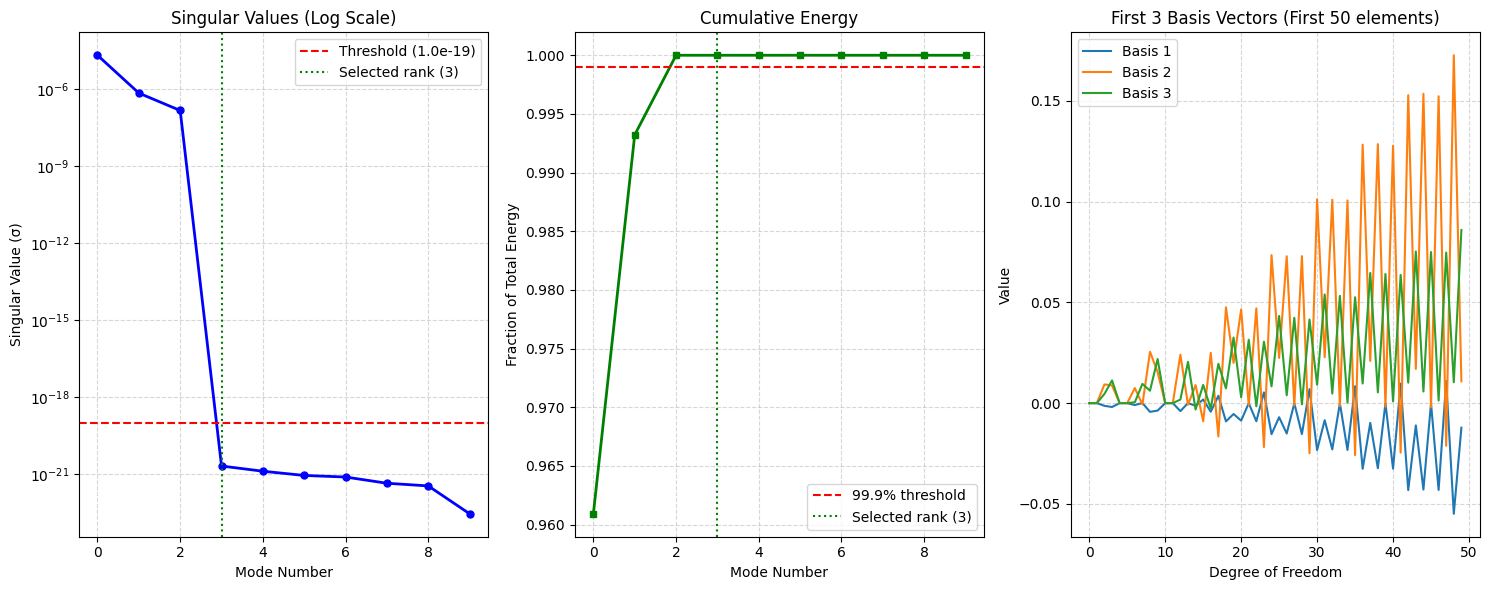


------------------------------ MATRIX PROPERTIES -------------------------------
Shape:                    (126, 10) (DOFs × snapshots)
Numerical rank:           3
Condition number:         7.24e+17
Effective rank (1e-10):   3

--------------------------- REDUCED BASIS SELECTION ----------------------------
Energy threshold:         0.999 (99.9%)
SV threshold:             1.0e-19
Rank by energy:           3 (captures 100.00% energy)
Rank by SV threshold:     3
Final selected rank:      3
Dimensionality reduction: 97.6% (126 → 3)

-------------------------------- MODE ANALYSIS ---------------------------------
+--------+------------------+---------------------+
| Mode   | Singular Value   | Cumulative Energy   |
+========+==================+=====================+
| 1      | 2.054e-05        | 96.09%              |
+--------+------------------+---------------------+
| 2      | 6.903e-07        | 99.32%              |
+--------+------------------+---------------------+
| 3      | 1.450e-

In [6]:
def perform_complete_svd_analysis(displacement_matrix, energy_threshold=0.999, sv_threshold=1e-19):
    """
    Perform complete SVD analysis with reduced basis computation and visualization.
    
    Parameters:
        displacement_matrix (np.ndarray): Matrix where each column is a processed displacement vector
        energy_threshold (float): Energy threshold for reduced basis (default: 0.999)
        sv_threshold (float): Singular value threshold (default: 1e-19)
        
    Returns:
        dict: Dictionary containing all SVD results and reduced basis
    """
    # ========================================================================
    # SVD Computation and Basic Analysis
    # ========================================================================
    print("\n" + "="*80)
    print(" COMPLETE SVD AND REDUCED BASIS ANALYSIS ".center(80))
    print("="*80)
    
    # Perform SVD
    U, S, VT = np.linalg.svd(displacement_matrix, full_matrices=False)
    num_modes = len(S)
    cum_energy = np.cumsum(S) / np.sum(S)
    
    # ========================================================================
    # Reduced Basis Computation
    # ========================================================================
    # Determine ranks based on different criteria
    r_energy = np.argmax(cum_energy >= energy_threshold) + 1 if any(cum_energy >= energy_threshold) else num_modes
    r_threshold = np.sum(S >= sv_threshold)
    final_rank = min(r_energy, r_threshold)
    V_r = U[:, :final_rank]
    
    # ========================================================================
    # Create comprehensive results dictionary
    # ========================================================================
    results = {
        # SVD components
        'U': U,
        'S': S,
        'VT': VT,
        'cumulative_energy': cum_energy,
        
        # Matrix properties
        'matrix_shape': displacement_matrix.shape,
        'rank': np.linalg.matrix_rank(displacement_matrix),
        'condition_number': np.max(S)/np.min(S) if np.min(S) > 0 else np.inf,
        'effective_rank': np.sum(S > 1e-10 * S[0]),
        'num_modes': num_modes,
        
        # Reduced basis results
        'energy_threshold': energy_threshold,
        'sv_threshold': sv_threshold,
        'r_energy': r_energy,
        'r_threshold': r_threshold,
        'final_rank': final_rank,
        'V_r': V_r,
        'dimensionality_reduction': 100*(1 - final_rank/displacement_matrix.shape[0])
    }
    
    # ========================================================================
    # Visualization
    # ========================================================================
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Singular values
    plt.subplot(1, 3, 1)
    plt.semilogy(S, 'b-', linewidth=2, marker='o', markersize=5)
    plt.title("Singular Values (Log Scale)", fontsize=12)
    plt.xlabel("Mode Number")
    plt.ylabel("Singular Value (σ)")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.axhline(y=sv_threshold, color='r', linestyle='--', label=f'Threshold ({sv_threshold:.1e})')
    plt.axvline(x=final_rank, color='g', linestyle=':', label=f'Selected rank ({final_rank})')
    plt.legend()
    
    # Plot 2: Cumulative energy
    plt.subplot(1, 3, 2)
    plt.plot(cum_energy, 'g-', linewidth=2, marker='s', markersize=5)
    plt.title("Cumulative Energy", fontsize=12)
    plt.xlabel("Mode Number")
    plt.ylabel("Fraction of Total Energy")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=energy_threshold, color='r', linestyle='--', label=f'{energy_threshold*100:.1f}% threshold')
    plt.axvline(x=final_rank, color='g', linestyle=':', label=f'Selected rank ({final_rank})')
    plt.legend()
    
    # Plot 3: First few basis vectors
    plt.subplot(1, 3, 3)
    for i in range(min(3, final_rank)):
        plt.plot(V_r[:50, i], label=f'Basis {i+1}')
    plt.title("First 3 Basis Vectors (First 50 elements)", fontsize=12)
    plt.xlabel("Degree of Freedom")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # ========================================================================
    # Text Output
    # ========================================================================
    print(f"\n{' MATRIX PROPERTIES ':-^80}")
    print(f"{'Shape:':<25} {displacement_matrix.shape} (DOFs × snapshots)")
    print(f"{'Numerical rank:':<25} {results['rank']}")
    print(f"{'Condition number:':<25} {results['condition_number']:.2e}")
    print(f"{'Effective rank (1e-10):':<25} {results['effective_rank']}")
    
    print(f"\n{' REDUCED BASIS SELECTION ':-^80}")
    print(f"{'Energy threshold:':<25} {energy_threshold:.3f} ({(energy_threshold*100):.1f}%)")
    print(f"{'SV threshold:':<25} {sv_threshold:.1e}")
    print(f"{'Rank by energy:':<25} {r_energy} (captures {cum_energy[r_energy-1]*100:.2f}% energy)")
    print(f"{'Rank by SV threshold:':<25} {r_threshold}")
    print(f"{'Final selected rank:':<25} {final_rank}")
    print(f"{'Dimensionality reduction:':<25} {results['dimensionality_reduction']:.1f}% "
          f"({displacement_matrix.shape[0]} → {final_rank})")
    
    print(f"\n{' MODE ANALYSIS ':-^80}")
    print(tabulate([
        ["1", f"{S[0]:.3e}", f"{cum_energy[0]*100:.2f}%"],
        ["2", f"{S[1]:.3e}", f"{cum_energy[1]*100:.2f}%"],
        ["3", f"{S[2]:.3e}", f"{cum_energy[2]*100:.2f}%"],
        ["...", "...", "..."],
        [str(final_rank), f"{S[final_rank-1]:.3e}", f"{cum_energy[final_rank-1]*100:.2f}%"],
        ["Full", f"{S[-1]:.3e}", "100.00%"]
    ], headers=["Mode", "Singular Value", "Cumulative Energy"], tablefmt="grid"))
    
    print(f"\n{' REDUCED BASIS PROPERTIES ':-^80}")
    print(f"{'Shape:':<25} {V_r.shape} (DOFs × modes)")
    print(f"{'Orthogonality check:':<25} Max off-diagonal: {np.max(np.abs(V_r.T @ V_r - np.eye(final_rank))):.2e}")
    print("\nFirst 5 elements of first 3 basis vectors:")
    for i in range(min(3, final_rank)):
        print(f"Basis {i+1}: {np.array2string(V_r[:5, i], precision=3, separator=', ')}")
    
    return results

# Example usage
if __name__ == "__main__":
    if 'displacement_matrix' in results and results['displacement_matrix'] is not None:
        # Perform complete analysis with default thresholds
        analysis_results = perform_complete_svd_analysis(
            displacement_matrix=results['displacement_matrix'],
            energy_threshold=0.999,  # 99.9% energy threshold
            sv_threshold=1e-19       # Singular value cutoff
        )
        
        # Accessing specific results example:
        print("\nAccessing specific results programmatically:")
        print(f"Reduced basis shape: {analysis_results['V_r'].shape}")
        print(f"First singular value: {analysis_results['S'][0]:.3e}")
        print(f"Dimensionality reduction: {analysis_results['dimensionality_reduction']:.1f}%")
    else:
        print("\nNo displacement matrix available for analysis")


                    COMPLETE SVD AND REDUCED BASIS ANALYSIS                     


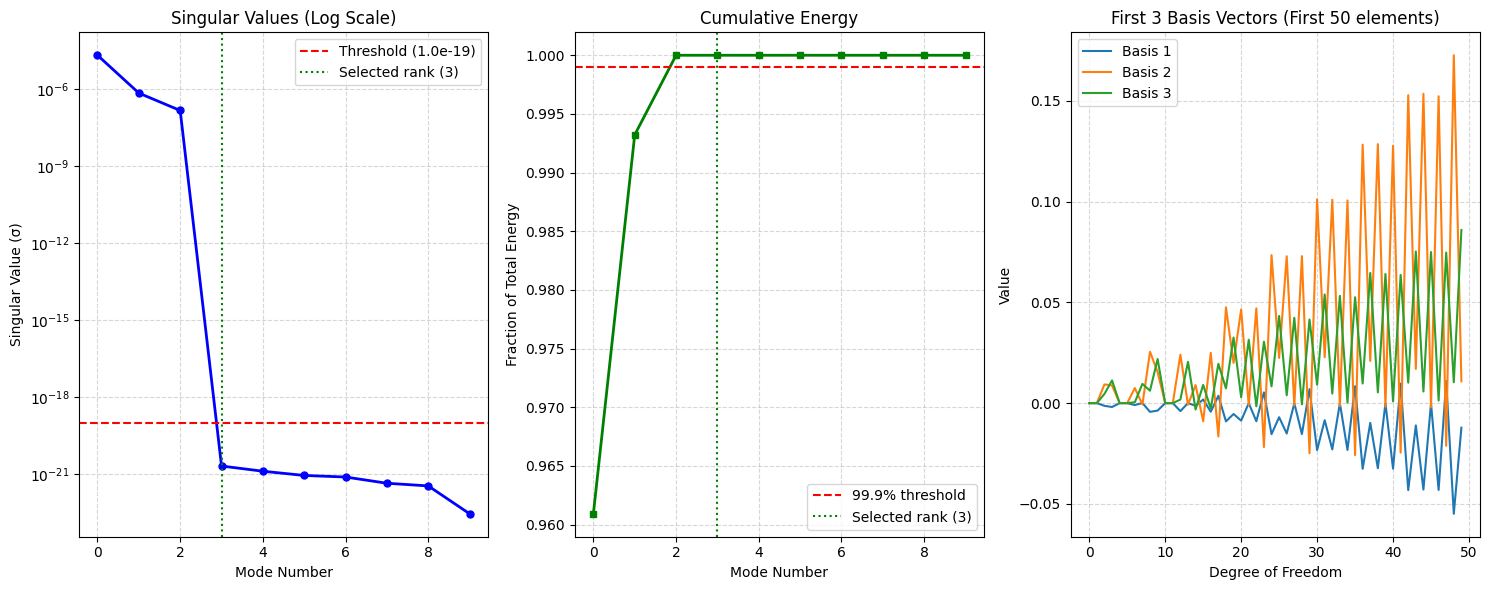


------------------------------ MATRIX PROPERTIES -------------------------------
Shape:                    (126, 10) (DOFs × snapshots)
Numerical rank:           3
Condition number:         7.24e+17
Effective rank (1e-10):   3

--------------------------- REDUCED BASIS SELECTION ----------------------------
Energy threshold:         0.999 (99.9%)
SV threshold:             1.0e-19
Rank by energy:           3 (captures 100.00% energy)
Rank by SV threshold:     3
Final selected rank:      3
Dimensionality reduction: 97.6% (126 → 3)

-------------------------------- MODE ANALYSIS ---------------------------------
+--------+------------------+---------------------+
| Mode   | Singular Value   | Cumulative Energy   |
+========+==================+=====================+
| 1      | 2.054e-05        | 96.09%              |
+--------+------------------+---------------------+
| 2      | 6.903e-07        | 99.32%              |
+--------+------------------+---------------------+
| 3      | 1.450e-

In [7]:
def perform_reduced_order_analysis(displacement_matrix, force_matrix, energy_threshold=0.999, sv_threshold=1e-19):
    """
    Perform complete reduced order analysis including:
    - SVD and reduced basis computation
    - Displacement and force projection
    - Pseudo-inverse calculation
    
    Parameters:
        displacement_matrix (np.ndarray): Displacement matrix (DOFs × snapshots)
        force_matrix (np.ndarray): Force matrix (DOFs × snapshots)
        energy_threshold (float): Energy threshold for basis selection (default: 0.999)
        sv_threshold (float): Singular value threshold (default: 1e-19)
        
    Returns:
        dict: Dictionary containing all analysis results
    """
    # ========================================================================
    # 1. Perform SVD and reduced basis computation
    # ========================================================================
    svd_results = perform_complete_svd_analysis(displacement_matrix, energy_threshold, sv_threshold)
    V_r = svd_results['V_r']
    
    # ========================================================================
    # 2. Project displacement and force matrices
    # ========================================================================
    print("\n" + "="*80)
    print(" REDUCED ORDER PROJECTION ANALYSIS ".center(80))
    print("="*80)
    
    # Project displacement matrix
    u_r = V_r.T @ displacement_matrix
    print(f"\n{' PROJECTED DISPLACEMENT MATRIX (u_r) ':-^80}")
    print(f"Shape: {u_r.shape} (modes × snapshots)")
    print(f"Norm: {np.linalg.norm(u_r):.3e}")
    
    # Compute pseudo-inverse
    u_r_pinv = np.linalg.pinv(u_r)
    print(f"\n{' PSEUDO-INVERSE OF u_r ':-^80}")
    print(f"Shape: {u_r_pinv.shape} (snapshots × modes)")
    print(f"Condition number: {np.linalg.cond(u_r):.3e}")
    
    # Project force matrix
    f_r = V_r.T @ force_matrix
    print(f"\n{' PROJECTED FORCE MATRIX (f_r) ':-^80}")
    print(f"Shape: {f_r.shape} (modes × snapshots)")
    print(f"Norm: {np.linalg.norm(f_r):.3e}")
    
    # ========================================================================
    # 3. Calculate and display projection errors
    # ========================================================================
    print(f"\n{' PROJECTION ERRORS ':-^80}")
    disp_error = np.linalg.norm(displacement_matrix - V_r @ u_r)/np.linalg.norm(displacement_matrix)
    force_error = np.linalg.norm(force_matrix - V_r @ f_r)/np.linalg.norm(force_matrix)
    
    print(f"{'Displacement projection error:':<35} {disp_error:.3e}")
    print(f"{'Force projection error:':<35} {force_error:.3e}")
    
    # ========================================================================
    # 4. Sample output of matrices
    # ========================================================================
    print(f"\n{' SAMPLE MATRIX CONTENTS ':-^80}")
    
    # Display sample of u_r
    print("\nFirst 3 modes × first 3 snapshots of u_r:")
    print(tabulate(
        [["Mode "+str(i+1)] + [f"{val:.3e}" for val in u_r[i,:3]] 
        for i in range(3)],  # Removed extra parenthesis here
        headers=[""]+[f"Snapshot {j+1}" for j in range(3)],
        tablefmt="grid"
    ))
    
    # Display sample of f_r
    print("\nFirst 3 modes × first 3 snapshots of f_r:")
    print(tabulate(
        [["Mode "+str(i+1)] + [f"{val:.3e}" for val in f_r[i,:3]] 
        for i in range(3)],  # Removed extra parenthesis here
        headers=[""]+[f"Case {j+1}" for j in range(3)],
        tablefmt="grid"
    ))
    
    # Display sample of pseudo-inverse
    print("\nFirst 3 rows × first 3 modes of u_r_pinv:")
    print(tabulate(
        [["Row "+str(i+1)] + [f"{val:.3e}" for val in u_r_pinv[i,:3]] 
        for i in range(3)],  # Removed extra parenthesis here
        headers=[""]+[f"Mode {j+1}" for j in range(3)],
        tablefmt="grid"
    ))
    
    # ========================================================================
    # Return all results
    # ========================================================================
    results = {
        'svd': svd_results,
        'projected_displacement': u_r,
        'projected_force': f_r,
        'pseudo_inverse': u_r_pinv,
        'projection_errors': {
            'displacement': disp_error,
            'force': force_error
        }
    }
    
    return results

# Example usage
if __name__ == "__main__":
    if all(k in results for k in ['displacement_matrix', 'force_matrix']):
        # Perform complete reduced order analysis
        reduced_results = perform_reduced_order_analysis(
            displacement_matrix=results['displacement_matrix'],
            force_matrix=results['force_matrix'],
            energy_threshold=0.999,
            sv_threshold=1e-19
        )

        # Extract and save the variables you need
        V_r = reduced_results['svd']['V_r']  # Reduced basis matrix (n×r)
        f_r = reduced_results['projected_force']  # Projected force matrix (r×m)
        u_r_pinv = reduced_results['pseudo_inverse']  # Pseudo-inverse (m×r)
        
        
        # Programmatic access to results
        print("\n" + "="*80)
        print(" PROGRAMMATIC ACCESS TO RESULTS ".center(80))
        print("="*80)
        print(f"Reduced basis shape: {reduced_results['svd']['V_r'].shape}")
        print(f"Projected displacement shape: {reduced_results['projected_displacement'].shape}")
        print(f"Projected force shape: {reduced_results['projected_force'].shape}")
        print(f"Pseudo-inverse shape: {reduced_results['pseudo_inverse'].shape}")
        print(f"Displacement projection error: {reduced_results['projection_errors']['displacement']:.3e}")
        print(f"Force projection error: {reduced_results['projection_errors']['force']:.3e}")
    else:
        print("\nRequired data not available. Need both displacement_matrix and force_matrix in results.")

In [8]:
def compute_reduced_stiffness(reduced_results):
    """
    Compute and analyze the reduced stiffness matrix K_r = f_r @ u_r_pinv
    
    Parameters:
        reduced_results (dict): Dictionary returned by perform_reduced_order_analysis()
        
    Returns:
        dict: Dictionary containing K_r and its properties
    """
    print("\n" + "="*80)
    print(" REDUCED STIFFNESS MATRIX COMPUTATION ".center(80))
    print("="*80)
    
    # Extract required matrices from reduced_results
    try:
        V_r = reduced_results['svd']['V_r']
        f_r = reduced_results['projected_force']
        u_r_pinv = reduced_results['pseudo_inverse']
    except KeyError as e:
        print(f"Error: Missing required matrix {e} in reduced_results")
        return None
    
    # 1. Compute reduced stiffness matrix
    K_r = f_r @ u_r_pinv
    
    # 2. Analyze matrix properties
    norm = np.linalg.norm(K_r)
    cond_num = np.linalg.cond(K_r)
    asymmetry = np.max(np.abs(K_r - K_r.T))
    is_symmetric = asymmetry < 1e-10
    
    # Eigenvalue analysis
    eigvals = np.linalg.eigvalsh(K_r) if is_symmetric else np.linalg.eigvals(K_r)
    min_eig = np.min(eigvals)
    max_eig = np.max(eigvals)
    is_positive_definite = np.all(eigvals > 0)
    
    # 3. Print results
    print(f"\nMatrix shape: {K_r.shape}")
    print(f"Condition number: {cond_num:.3e}")
    print(f"Norm: {norm:.3e}")
    print(f"\nSymmetry check:")
    print(f"Max asymmetry: {asymmetry:.3e}")
    print(f"Is symmetric: {'Yes' if is_symmetric else 'No'}")
    
    print(f"\nEigenvalue analysis:")
    print(f"Min eigenvalue: {min_eig:.3e}")
    print(f"Max eigenvalue: {max_eig:.3e}")
    print(f"Is positive definite: {'Yes' if is_positive_definite else 'No'}")
    
    # # 4. Print matrix contents
    # print(f"\nMatrix contents (first 5×5 block if large):")
    # if K_r.shape[0] <= 10:
    #     print(np.array2string(K_r, precision=3, suppress_small=True))
    # else:
    #     print(np.array2string(K_r[:5, :5], precision=3, suppress_small=True))
    
    return {
        'K_r': K_r,
        'properties': {
            'shape': K_r.shape,
            'norm': norm,
            'condition_number': cond_num,
            'is_symmetric': is_symmetric,
            'max_asymmetry': asymmetry,
            'eigenvalues': eigvals,
            'is_positive_definite': is_positive_definite
        }
    }

# Example usage
if __name__ == "__main__":
    # First perform reduced order analysis to get the necessary matrices
    if all(k in results for k in ['displacement_matrix', 'force_matrix']):
        # reduced_results = perform_reduced_order_analysis(
        #     displacement_matrix=results['displacement_matrix'],
        #     force_matrix=results['force_matrix'],
        #     energy_threshold=0.999,
        #     sv_threshold=1e-19
        # )
        
        # Now compute reduced stiffness using the returned reduced_results
        stiffness_results = compute_reduced_stiffness(reduced_results)
        
        if stiffness_results is not None:
            # Programmatic access example
            print("\n" + "="*80)
            print(" PROGRAMMATIC ACCESS TO RESULTS ".center(80))
            print("="*80)
            print(f"Reduced stiffness matrix shape: {stiffness_results['K_r'].shape}")
            print(f"Condition number: {stiffness_results['properties']['condition_number']:.3e}")
            print(f"Is positive definite? {stiffness_results['properties']['is_positive_definite']}")
            print(stiffness_results['K_r'])
    else:
        print("Required input matrices not found. Need displacement_matrix and force_matrix in results.")


                      REDUCED STIFFNESS MATRIX COMPUTATION                      

Matrix shape: (3, 3)
Condition number: 8.292e+00
Norm: 2.088e-05

Symmetry check:
Max asymmetry: 2.477e-06
Is symmetric: No

Eigenvalue analysis:
Min eigenvalue: 2.015e-06
Max eigenvalue: 1.626e-05
Is positive definite: Yes

                         PROGRAMMATIC ACCESS TO RESULTS                         
Reduced stiffness matrix shape: (3, 3)
Condition number: 8.292e+00
Is positive definite? True
[[ 4.07181043e-06 -3.93524069e-06 -1.14609348e-06]
 [-4.56752358e-06  1.04088432e-05 -3.58957872e-08]
 [ 1.33061920e-06 -5.15201205e-07  1.64701537e-05]]


In [9]:
print(f"Displacement matrix shape: {results['displacement_matrix'].shape}")
print(f"Stiffness matrix shape: {results['stiffness_matrices'][0].shape}")
print(f"Force matrix shape: {results['force_matrix'].shape}")

Displacement matrix shape: (126, 10)
Stiffness matrix shape: (126, 126)
Force matrix shape: (126, 10)


In [10]:
# Print the size of reduced matrices
print(f"Reduced displacement matrix size: {reduced_results['projected_displacement'].shape}")
print(f"Reduced stiffness matrix size: {stiffness_results['K_r'].shape}")
print(f"Reduced force matrix size: {reduced_results['projected_force'].shape}")

Reduced displacement matrix size: (3, 10)
Reduced stiffness matrix size: (3, 3)
Reduced force matrix size: (3, 10)


In [11]:
# Constants
TOLERANCE = 1e-5
NUM_NODES_TO_SHOW = 5
PERCENTILES = [25, 50, 75, 90, 95, 99]
RESULTS_DIR = os.path.join(DISPLACEMENT_PATH, "..", "ROM_Results")

class ROMAnalyzer:
    def __init__(self, K_r, V_r):
        self.K_r = K_r
        self.V_r = V_r['V_r']
        self.displacement_path = DISPLACEMENT_PATH
        self.loading_path = LOADING_PATH
        
        # Clean and create fresh results directory
        self._clean_results_directory()
        print(f"\n{' ROM Analysis Initialized ':=^80}")
        print(f"Results will be saved to: {RESULTS_DIR}\n")

    def _clean_results_directory(self):
        """Remove existing results directory and create fresh one"""
        try:
            if os.path.exists(RESULTS_DIR):
                shutil.rmtree(RESULTS_DIR)
            os.makedirs(RESULTS_DIR, exist_ok=True)
        except Exception as e:
            print(f"Warning: Could not clean results directory - {str(e)}")

    @staticmethod
    def is_effectively_zero(value, tolerance=TOLERANCE):
        return np.abs(value) < tolerance

    def process_displacement_vector(self, displacement):
        """Remove z-component and flatten displacement vector"""
        disp_3d = displacement.reshape(-1, 3)
        disp_2d = disp_3d[:, :2]  # Keep only X and Y components
        return disp_2d.reshape(-1)  # Flatten to 1D array

    def get_all_load_cases(self):
        """Get all valid load cases from displacement files"""
        try:
            files = os.listdir(self.displacement_path)
            load_cases = []
            
            for file in files:
                if file.startswith("displacements_modulus_") and file.endswith(".npy"):
                    try:
                        load_case = file[len("displacements_modulus_"):-len(".npy")]
                        if re.match(r'^\[.*\]$', load_case):
                            load_cases.append(load_case)
                    except Exception:
                        continue
            
            if not load_cases:
                print("Warning: No valid load cases found in displacement directory!")
            return sorted(load_cases)
        except Exception as e:
            print(f"Error accessing displacement directory: {str(e)}")
            return []

    def load_force_vector(self, load_case):
        """Load force vector with validation"""
        force_file = f"global_force_vector_{load_case}.npy"
        force_path = os.path.join(self.loading_path, force_file)
        
        if not os.path.exists(force_path):
            raise FileNotFoundError(f"Force file not found: {force_path}")
            
        force_data = np.load(force_path)
        if force_data.size == 0:
            raise ValueError("Force vector is empty")
        return force_data

    def load_displacement_vector(self, load_case):
        """Load and validate displacement vector"""
        disp_file = f"displacements_modulus_{load_case}.npy"
        disp_path = os.path.join(self.displacement_path, disp_file)
        
        if not os.path.exists(disp_path):
            raise FileNotFoundError(f"Displacement file not found: {disp_path}")
            
        displacement = np.load(disp_path)
        if displacement.size == 0:
            raise ValueError("Displacement vector is empty")
        return self.process_displacement_vector(displacement)

    def calculate_reduced_force(self, F_full):
        """Calculate reduced force vector with dimension check"""
        if F_full.shape[0] != self.V_r.shape[0]:
            raise ValueError(f"Dimension mismatch: F_full {F_full.shape} vs V_r {self.V_r.shape}")
        return self.V_r.T @ F_full

    def calculate_displacements(self, F_reduced):
        """Calculate displacements with error handling"""
        try:
            u_reduced = solve(self.K_r, F_reduced)
            u_full = self.V_r @ u_reduced
            return u_reduced, u_full
        except np.linalg.LinAlgError as e:
            raise RuntimeError(f"Matrix solving failed: {str(e)}")

    def save_results(self, case_dir, results):
        """Save all results to analysis and results folders within case directory"""
        # Create subdirectories
        analysis_dir = os.path.join(case_dir, "analysis")
        results_dir = os.path.join(case_dir, "results")
        os.makedirs(analysis_dir, exist_ok=True)
        os.makedirs(results_dir, exist_ok=True)
        
        # Save analysis data (reduced system results)
        np.save(os.path.join(analysis_dir, "u_reduced.npy"), results['u_reduced'])
        np.save(os.path.join(analysis_dir, "F_reduced.npy"), results['F_reduced'])
        
        # Save full results
        np.save(os.path.join(results_dir, "u_full.npy"), results['u_full'])
        np.save(os.path.join(results_dir, "diff_mag.npy"), results['diff_mag'])
        np.save(os.path.join(results_dir, "sig_indices.npy"), results['sig_indices'])
        
        # Save metadata
        with open(os.path.join(case_dir, "case_info.txt"), 'w', encoding='utf-8') as f:
            f.write(f"Load Case: {results['load_case']}\n")
            f.write(f"Nodes with significant differences: {results['num_sig_diffs']}\n")
            f.write(f"Percentage different: {results['pct_diff']:.2f}%\n")
            f.write(f"Max difference: {results['max_diff']:.3e}\n")
            f.write(f"Mean difference: {results['mean_diff']:.3e}\n")

    def process_load_case(self, load_case):
        """Process a single load case and return results"""
        results = {'load_case': load_case, 'success': False}
        
        try:
            # Load and process data
            F_full = self.load_force_vector(load_case)
            F_reduced = self.calculate_reduced_force(F_full)
            u_reduced, rom_disp = self.calculate_displacements(F_reduced)
            actual_disp = self.load_displacement_vector(load_case)
            
            # Ensure dimensions match
            if rom_disp.shape != actual_disp.shape:
                rom_disp = self.process_displacement_vector(rom_disp.reshape(-1, 3))
            
            # Calculate differences
            actual_2d = actual_disp.reshape(-1, 2)
            rom_2d = rom_disp.reshape(-1, 2)
            diff = actual_2d - rom_2d
            diff_mag = np.linalg.norm(diff, axis=1)
            
            # Significant differences
            sig_mask = ~self.is_effectively_zero(diff_mag)
            sig_indices = np.where(sig_mask)[0]
            num_sig_diffs = len(sig_indices)
            
            # Prepare results dictionary
            results.update({
                'u_reduced': u_reduced,
                'u_full': rom_disp,
                'F_reduced': F_reduced,
                'diff_mag': diff_mag,
                'sig_indices': sig_indices,
                'num_sig_diffs': num_sig_diffs,
                'pct_diff': num_sig_diffs/actual_2d.shape[0]*100,
                'max_diff': np.max(diff_mag[sig_indices]) if num_sig_diffs > 0 else 0,
                'mean_diff': np.mean(diff_mag[sig_indices]) if num_sig_diffs > 0 else 0,
                'success': True
            })
            
        except Exception as e:
            results['error'] = str(e)
            
        return results

    def print_case_summary(self, results):
        """Print formatted summary for a single case"""
        print(f"\n{' Case Summary ':=^80}")
        print(f"Load Case: {results['load_case']}")
        
        if not results['success']:
            print(f"\nError: Processing failed: {results.get('error', 'Unknown error')}")
            return
        
        # Create summary table (using text instead of emoji for Windows compatibility)
        summary_data = [
            ["Nodes with differences", f"{results['num_sig_diffs']} ({results['pct_diff']:.2f}%)"],
            ["Maximum difference", f"{results['max_diff']:.3e}"],
            ["Mean difference", f"{results['mean_diff']:.3e}"],
            ["Reduced displacement shape", str(results['u_reduced'].shape)],
            ["Full displacement shape", str(results['u_full'].shape)]
        ]
        
        print("\n" + tabulate(summary_data, headers=["Metric", "Value"], tablefmt="grid"))
        
        # Show worst nodes if any differences exist
        if results['num_sig_diffs'] > 0:
            diff_mag = results['diff_mag']
            sig_indices = results['sig_indices']
            worst_indices = sig_indices[np.argsort(diff_mag[sig_indices])[-NUM_NODES_TO_SHOW:]]
            
            print(f"\nTop {NUM_NODES_TO_SHOW} nodes with largest differences:")
            worst_nodes_data = []
            for node in reversed(worst_indices):
                worst_nodes_data.append([
                    node,
                    f"{diff_mag[node]:.3e}",
                    f"{results['u_full'][node*2]:.3e}",
                    f"{results['u_full'][node*2+1]:.3e}"
                ])
            
            print(tabulate(
                worst_nodes_data,
                headers=["Node", "Difference", "ROM X", "ROM Y"],
                tablefmt="grid"
            ))

    def run_analysis(self):
        """Execute analysis for all load cases"""
        load_cases = self.get_all_load_cases()
        if not load_cases:
            return False
        
        print(f"Found {len(load_cases)} load cases to process\n")
        
        all_results = []
        for i, load_case in enumerate(load_cases, 1):
            print(f"Processing {i}/{len(load_cases)}: {load_case[:50]}...")
            
            # Create case directory name (sanitize special characters)
            case_dir_name = f"case_[{load_case.replace('[', '').replace(']', '').replace(', ', '_')[:50]}]"
            case_dir = os.path.join(RESULTS_DIR, case_dir_name)
            
            # Process the case
            results = self.process_load_case(load_case)
            results['case_dir'] = case_dir
            
            # Save results if successful
            if results['success']:
                self.save_results(case_dir, results)
                print(f"Success - results saved to {case_dir}")
            else:
                print(f"Failed - {results.get('error', 'Unknown error')}")
            
            # Print summary and store for final report
            self.print_case_summary(results)
            all_results.append(results)
        
        # Generate final report
        self.generate_final_report(all_results)
        return True

    def generate_final_report(self, all_results):
        """Create a comprehensive final report"""
        # Prepare data for summary table
        summary_data = []
        success_count = 0
        
        for res in all_results:
            if res['success']:
                success_count += 1
                summary_data.append([
                    res['load_case'],
                    "Success",
                    f"{res['num_sig_diffs']}",
                    f"{res['pct_diff']:.2f}%",
                    f"{res['max_diff']:.3e}",
                    res['case_dir']
                ])
            else:
                summary_data.append([
                    res['load_case'],
                    "Failed",
                    "N/A",
                    "N/A",
                    "N/A",
                    res.get('error', 'Unknown error')
                ])
        
        # Print final summary
        print(f"\n{' Final Summary ':=^80}")
        print(f"Successfully processed: {success_count}/{len(all_results)} cases\n")
        
        print(tabulate(
            summary_data,
            headers=["Load Case", "Status", "Differences", "Percentage", "Max Diff", "Location/Error"],
            tablefmt="grid"
        ))
        
        # Save report to file with UTF-8 encoding
        report_path = os.path.join(RESULTS_DIR, "analysis_summary.txt")
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("ROM Analysis Summary\n")
            f.write("="*50 + "\n")
            f.write(f"Total cases: {len(all_results)}\n")
            f.write(f"Successful: {success_count}\n")
            f.write(f"Failed: {len(all_results) - success_count}\n\n")
            f.write(tabulate(
                summary_data,
                headers=["Load Case", "Status", "Differences", "Percentage", "Max Diff", "Location/Error"],
                tablefmt="plain"
            ))
        
        print(f"\nDetailed report saved to: {report_path}")

# Example usage
if __name__ == "__main__":
    try:
        print("\nStarting ROM Analysis...")
        # Make sure to define DISPLACEMENT_PATH, LOADING_PATH, stiffness_results, and reduced_results
        analyzer = ROMAnalyzer(stiffness_results['K_r'], reduced_results['svd'])
        
        if analyzer.run_analysis():
            print("\nAnalysis completed successfully!")
        else:
            print("\nAnalysis completed with errors!")
            
    except Exception as e:
        print(f"\nFatal error: {str(e)}")


Starting ROM Analysis...

=========================== ROM Analysis Initialized ===========================
Results will be saved to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\displacement_results\..\ROM_Results

Found 10 load cases to process

Processing 1/10: [-127.38, 115.42, 208.84]...
Success - results saved to d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\displacement_results\..\ROM_Results\case_[-127.38_115.42_208.84]

================================= Case Summary =================================
Load Case: [-127.38, 115.42, 208.84]

+----------------------------+-----------+
| Metric                     | Value     |
+============================+===========+
| Nodes with differences     | 0 (0.00%) |
+----------------------------+-----------+
| Maximum difference         | 0.000e+00 |
+----------------------------+-----------+
| Mean difference            | 0.000e+00 |
+----------------------------+-----------+
| Reduced displacement

Mesh information: 63 nodes, 80 elements

Processing case: displacements_modulus_[-127.38, 115.42, 208.84]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[-127.38_115.42_208.84]\displacement_comparison_displacements_modulus_[-127.38, 115.42, 208.84].png


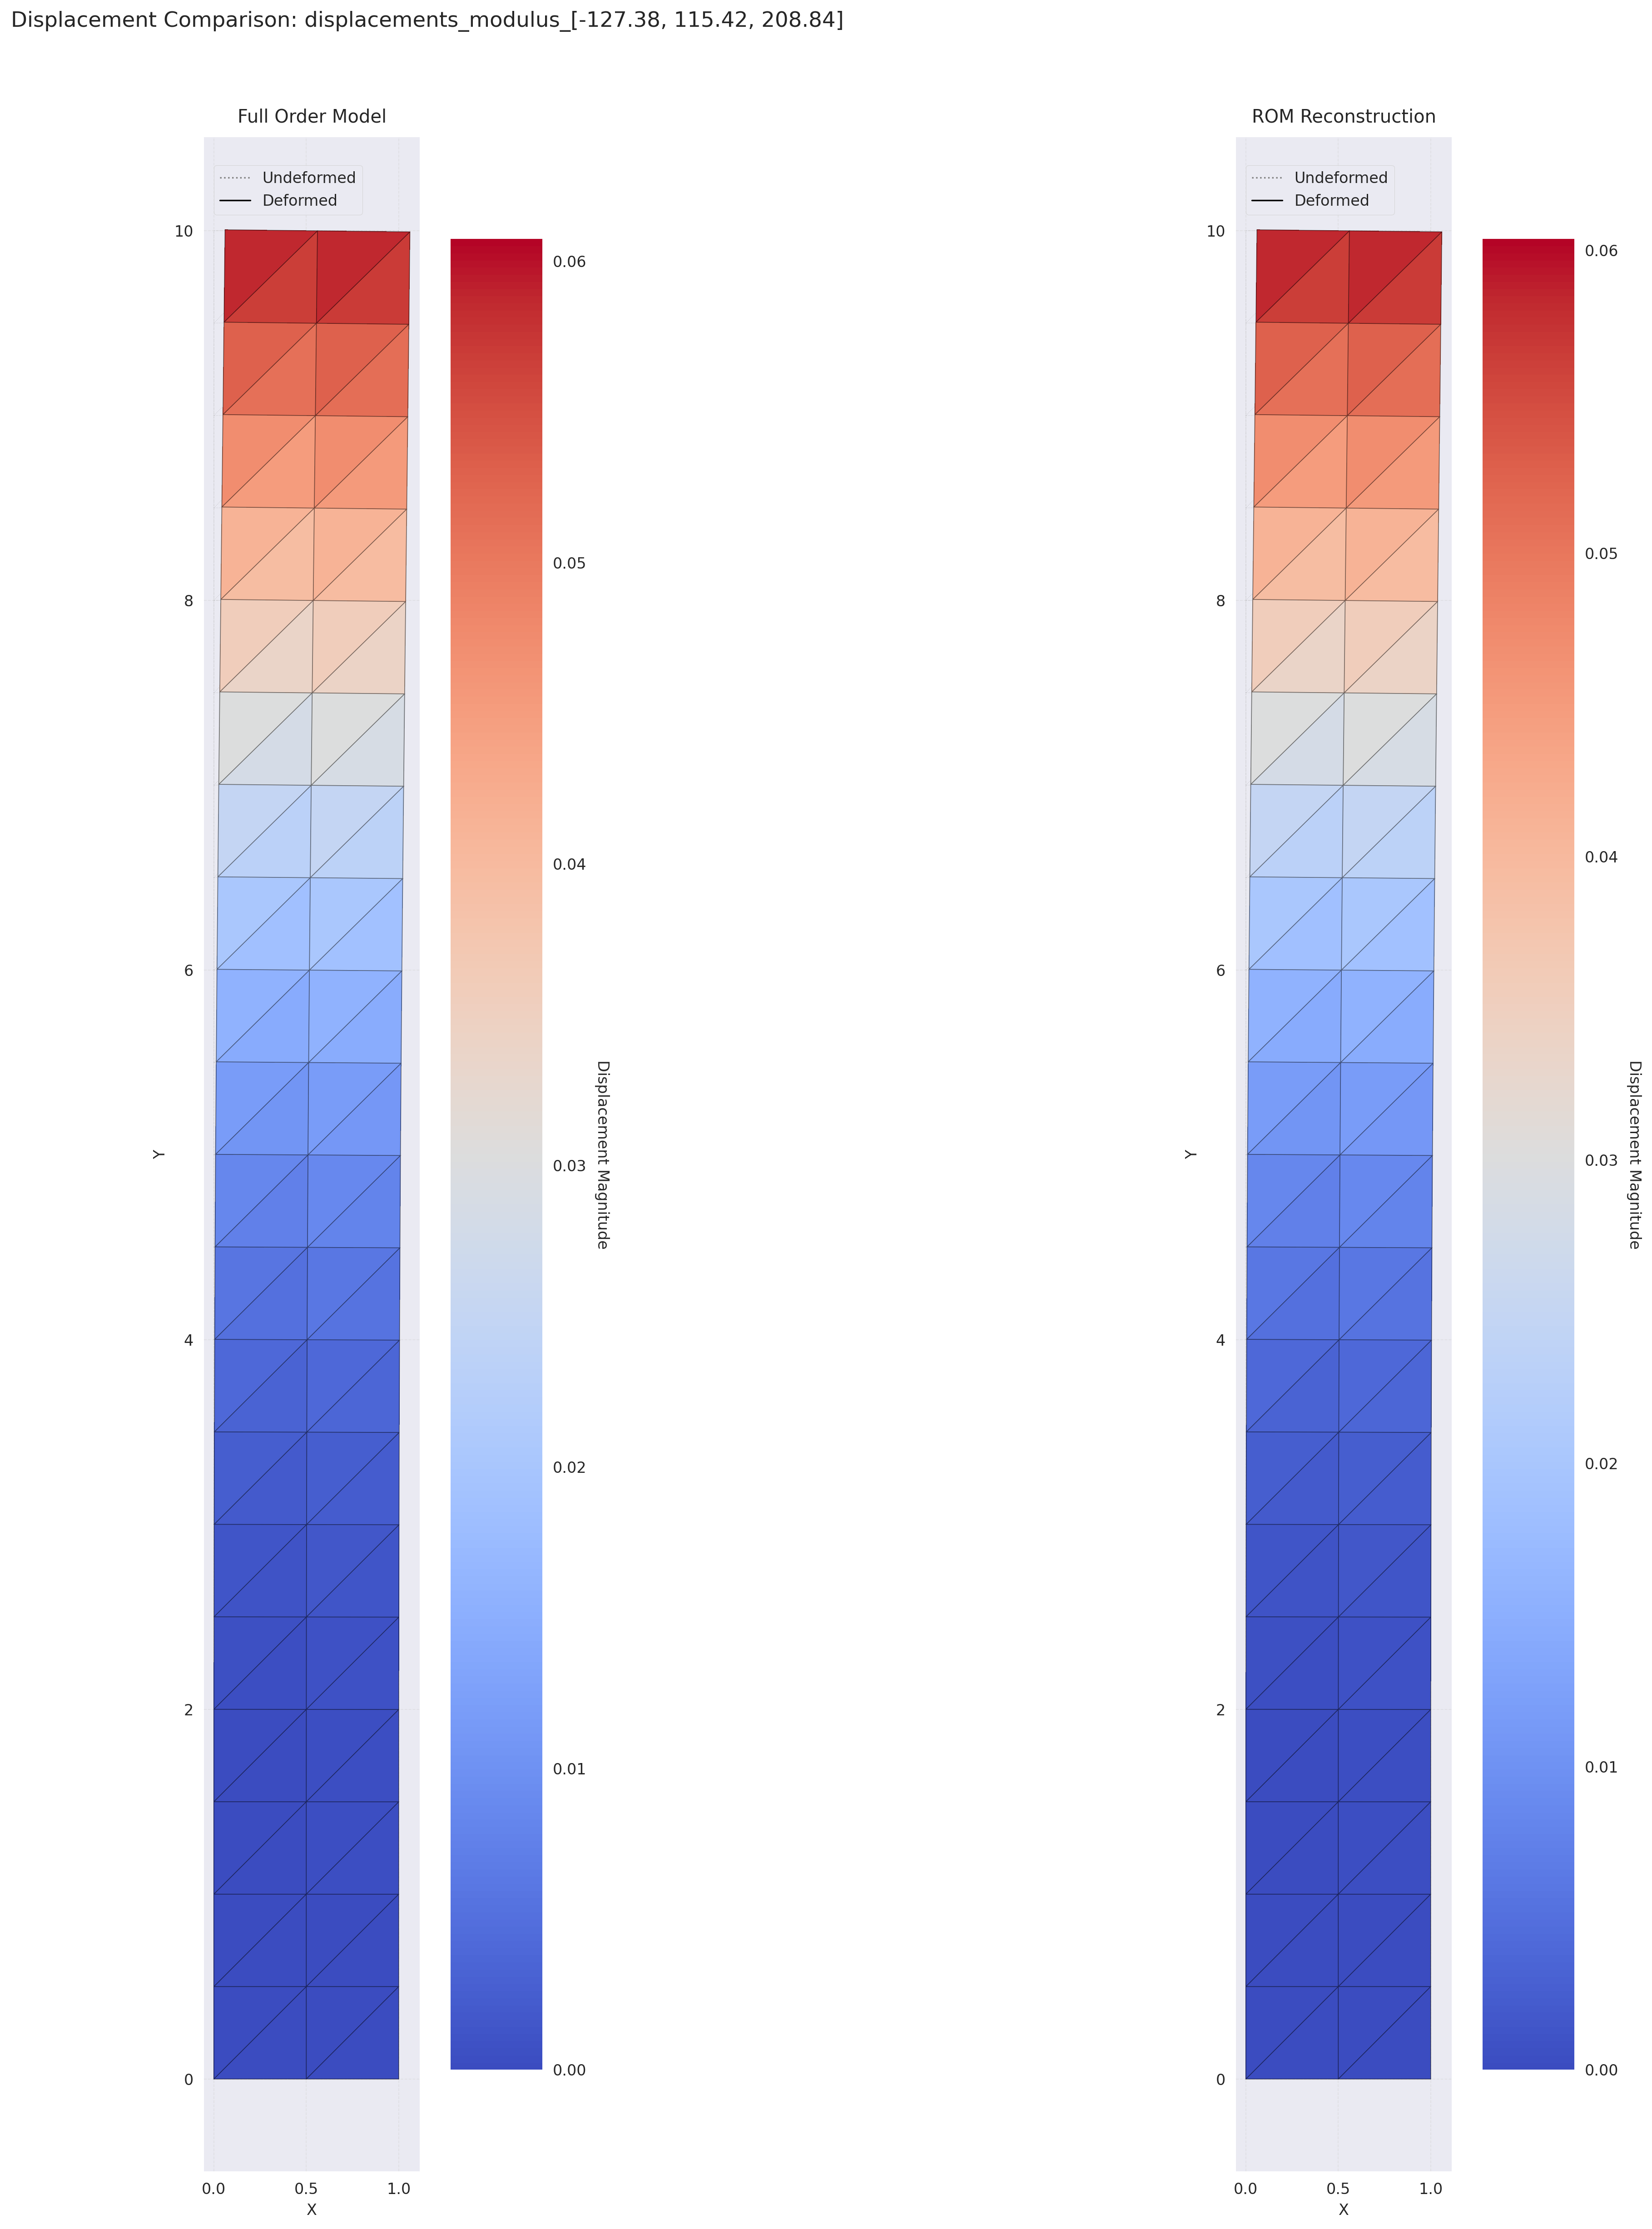


Comparison Metrics:
Max difference: 3.71e-04
Mean difference: 1.09e-04
Relative error: 0.60%

Processing case: displacements_modulus_[-161.03, 352.18, -105.52]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[-161.03_352.18_-105.52]\displacement_comparison_displacements_modulus_[-161.03, 352.18, -105.52].png


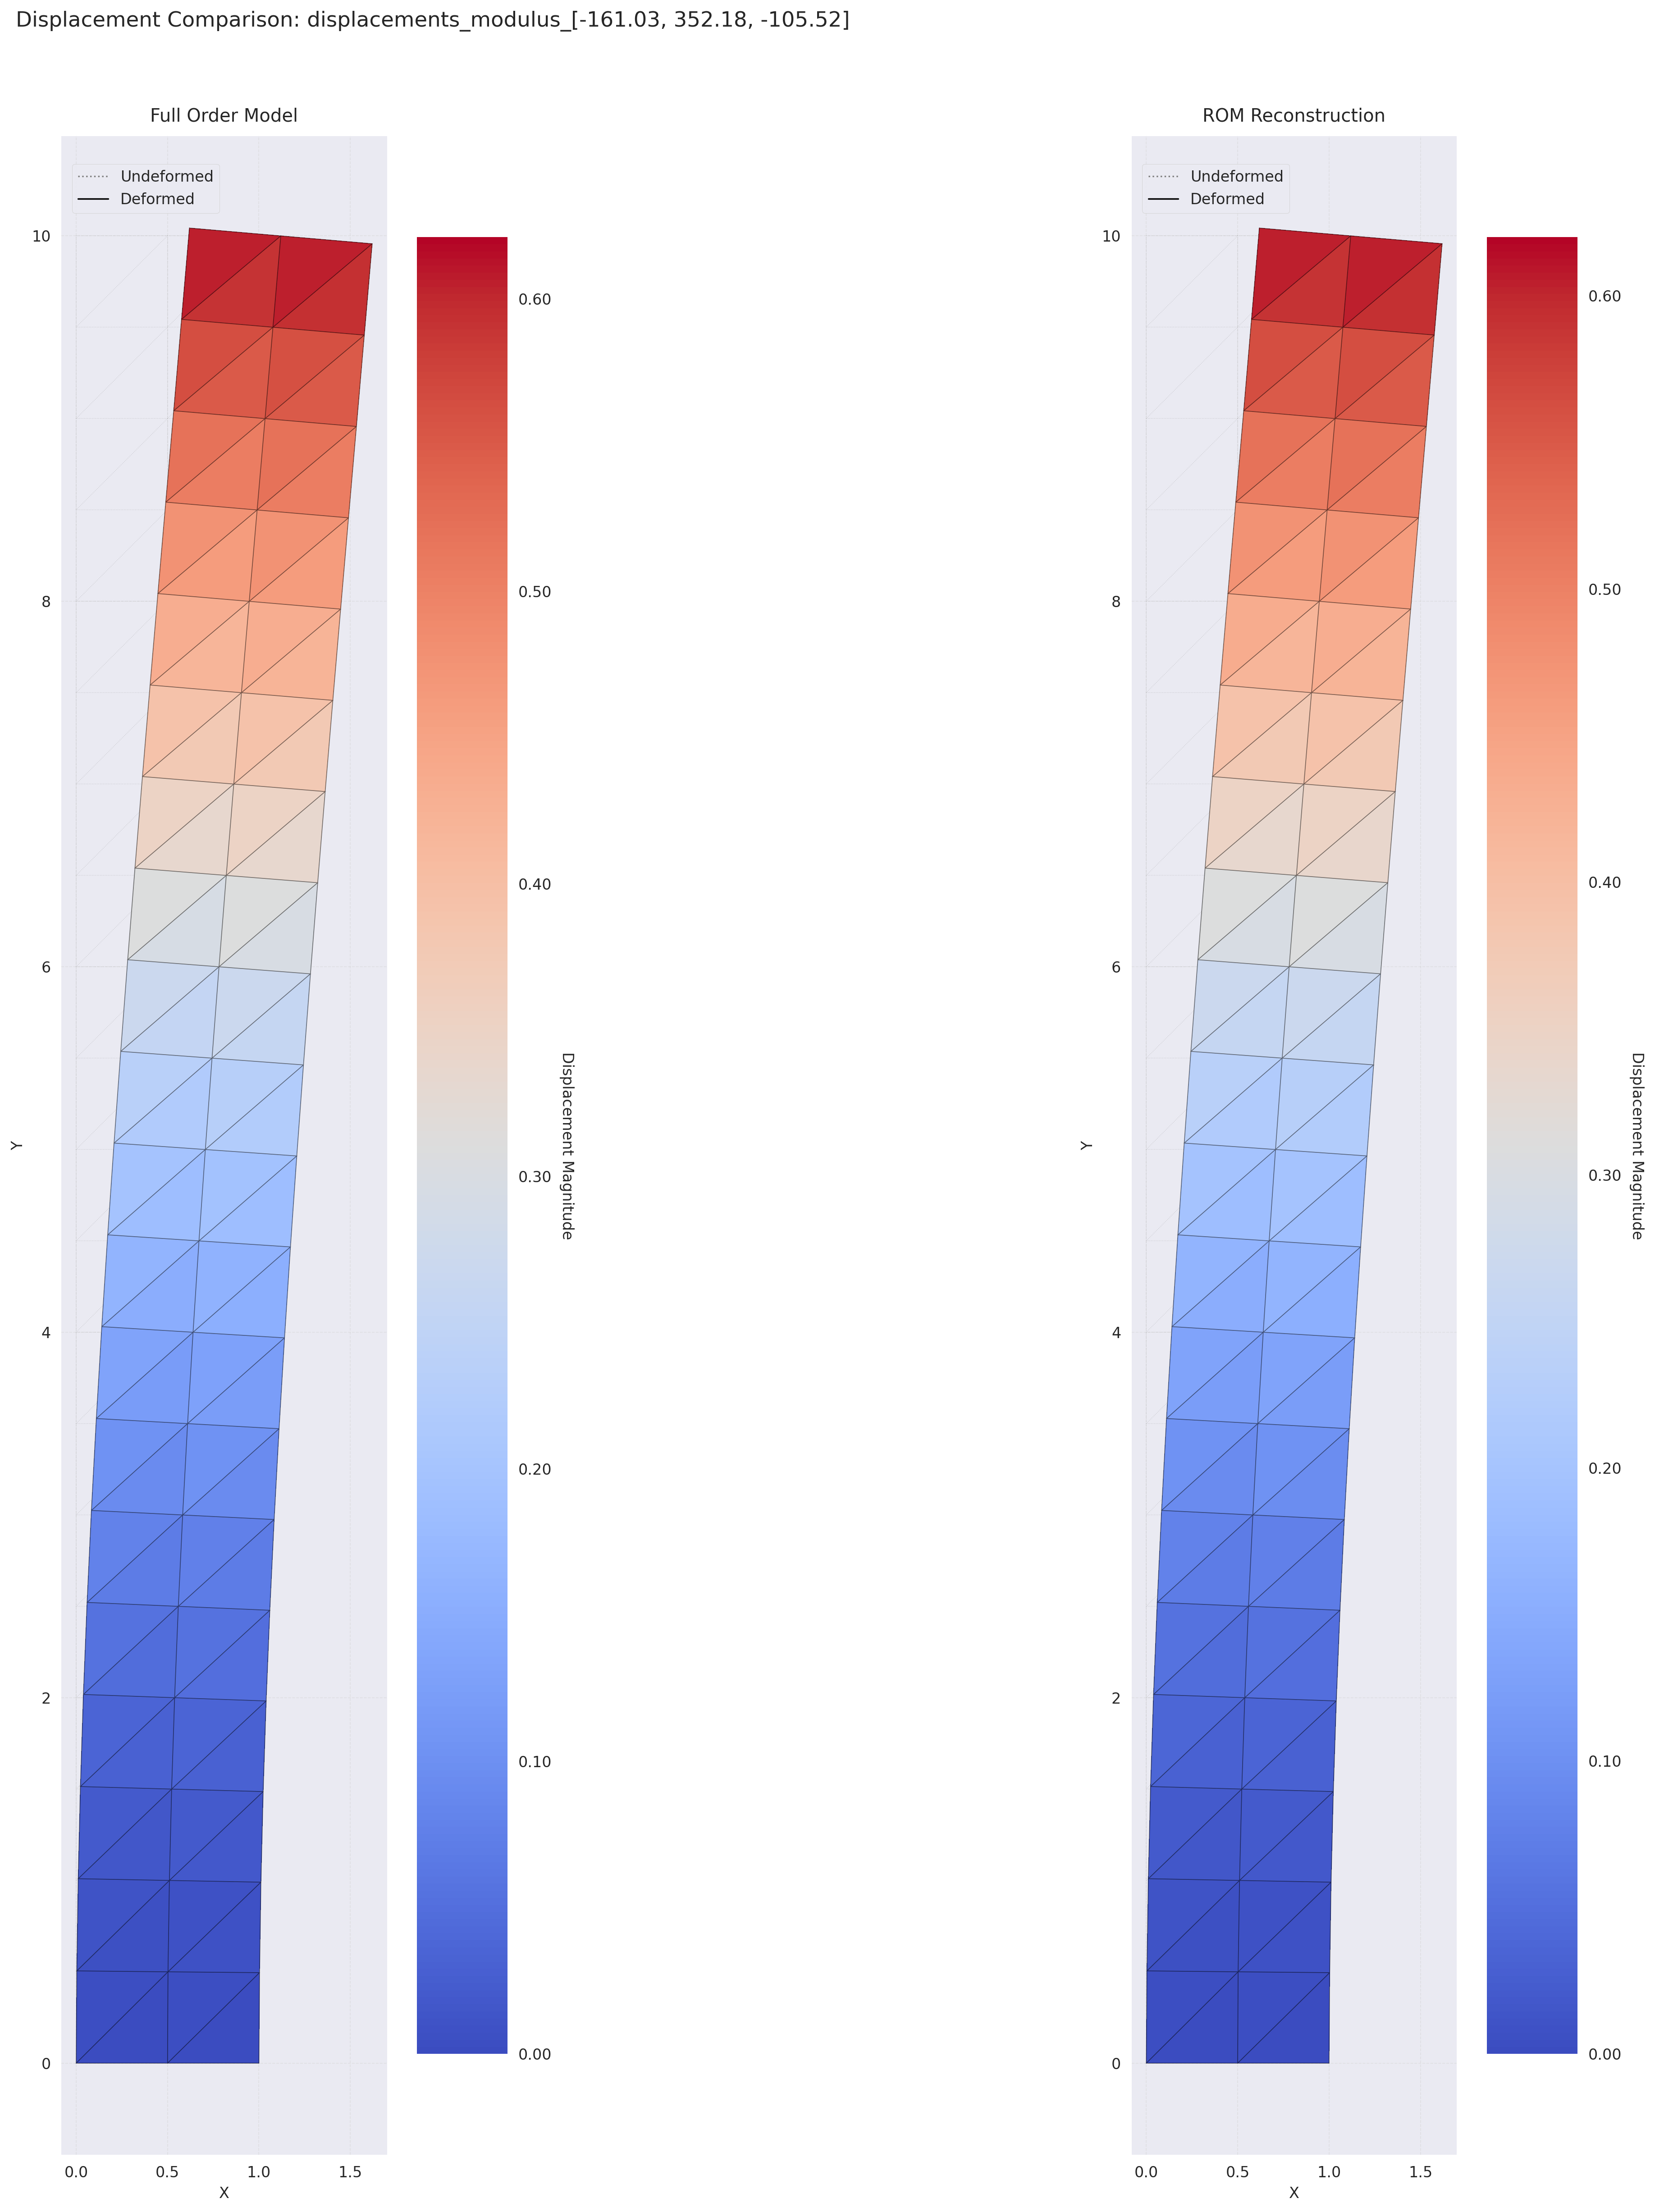


Comparison Metrics:
Max difference: 1.14e-03
Mean difference: 3.20e-04
Relative error: 0.13%

Processing case: displacements_modulus_[-180.46, 286.94, 297.75]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[-180.46_286.94_297.75]\displacement_comparison_displacements_modulus_[-180.46, 286.94, 297.75].png


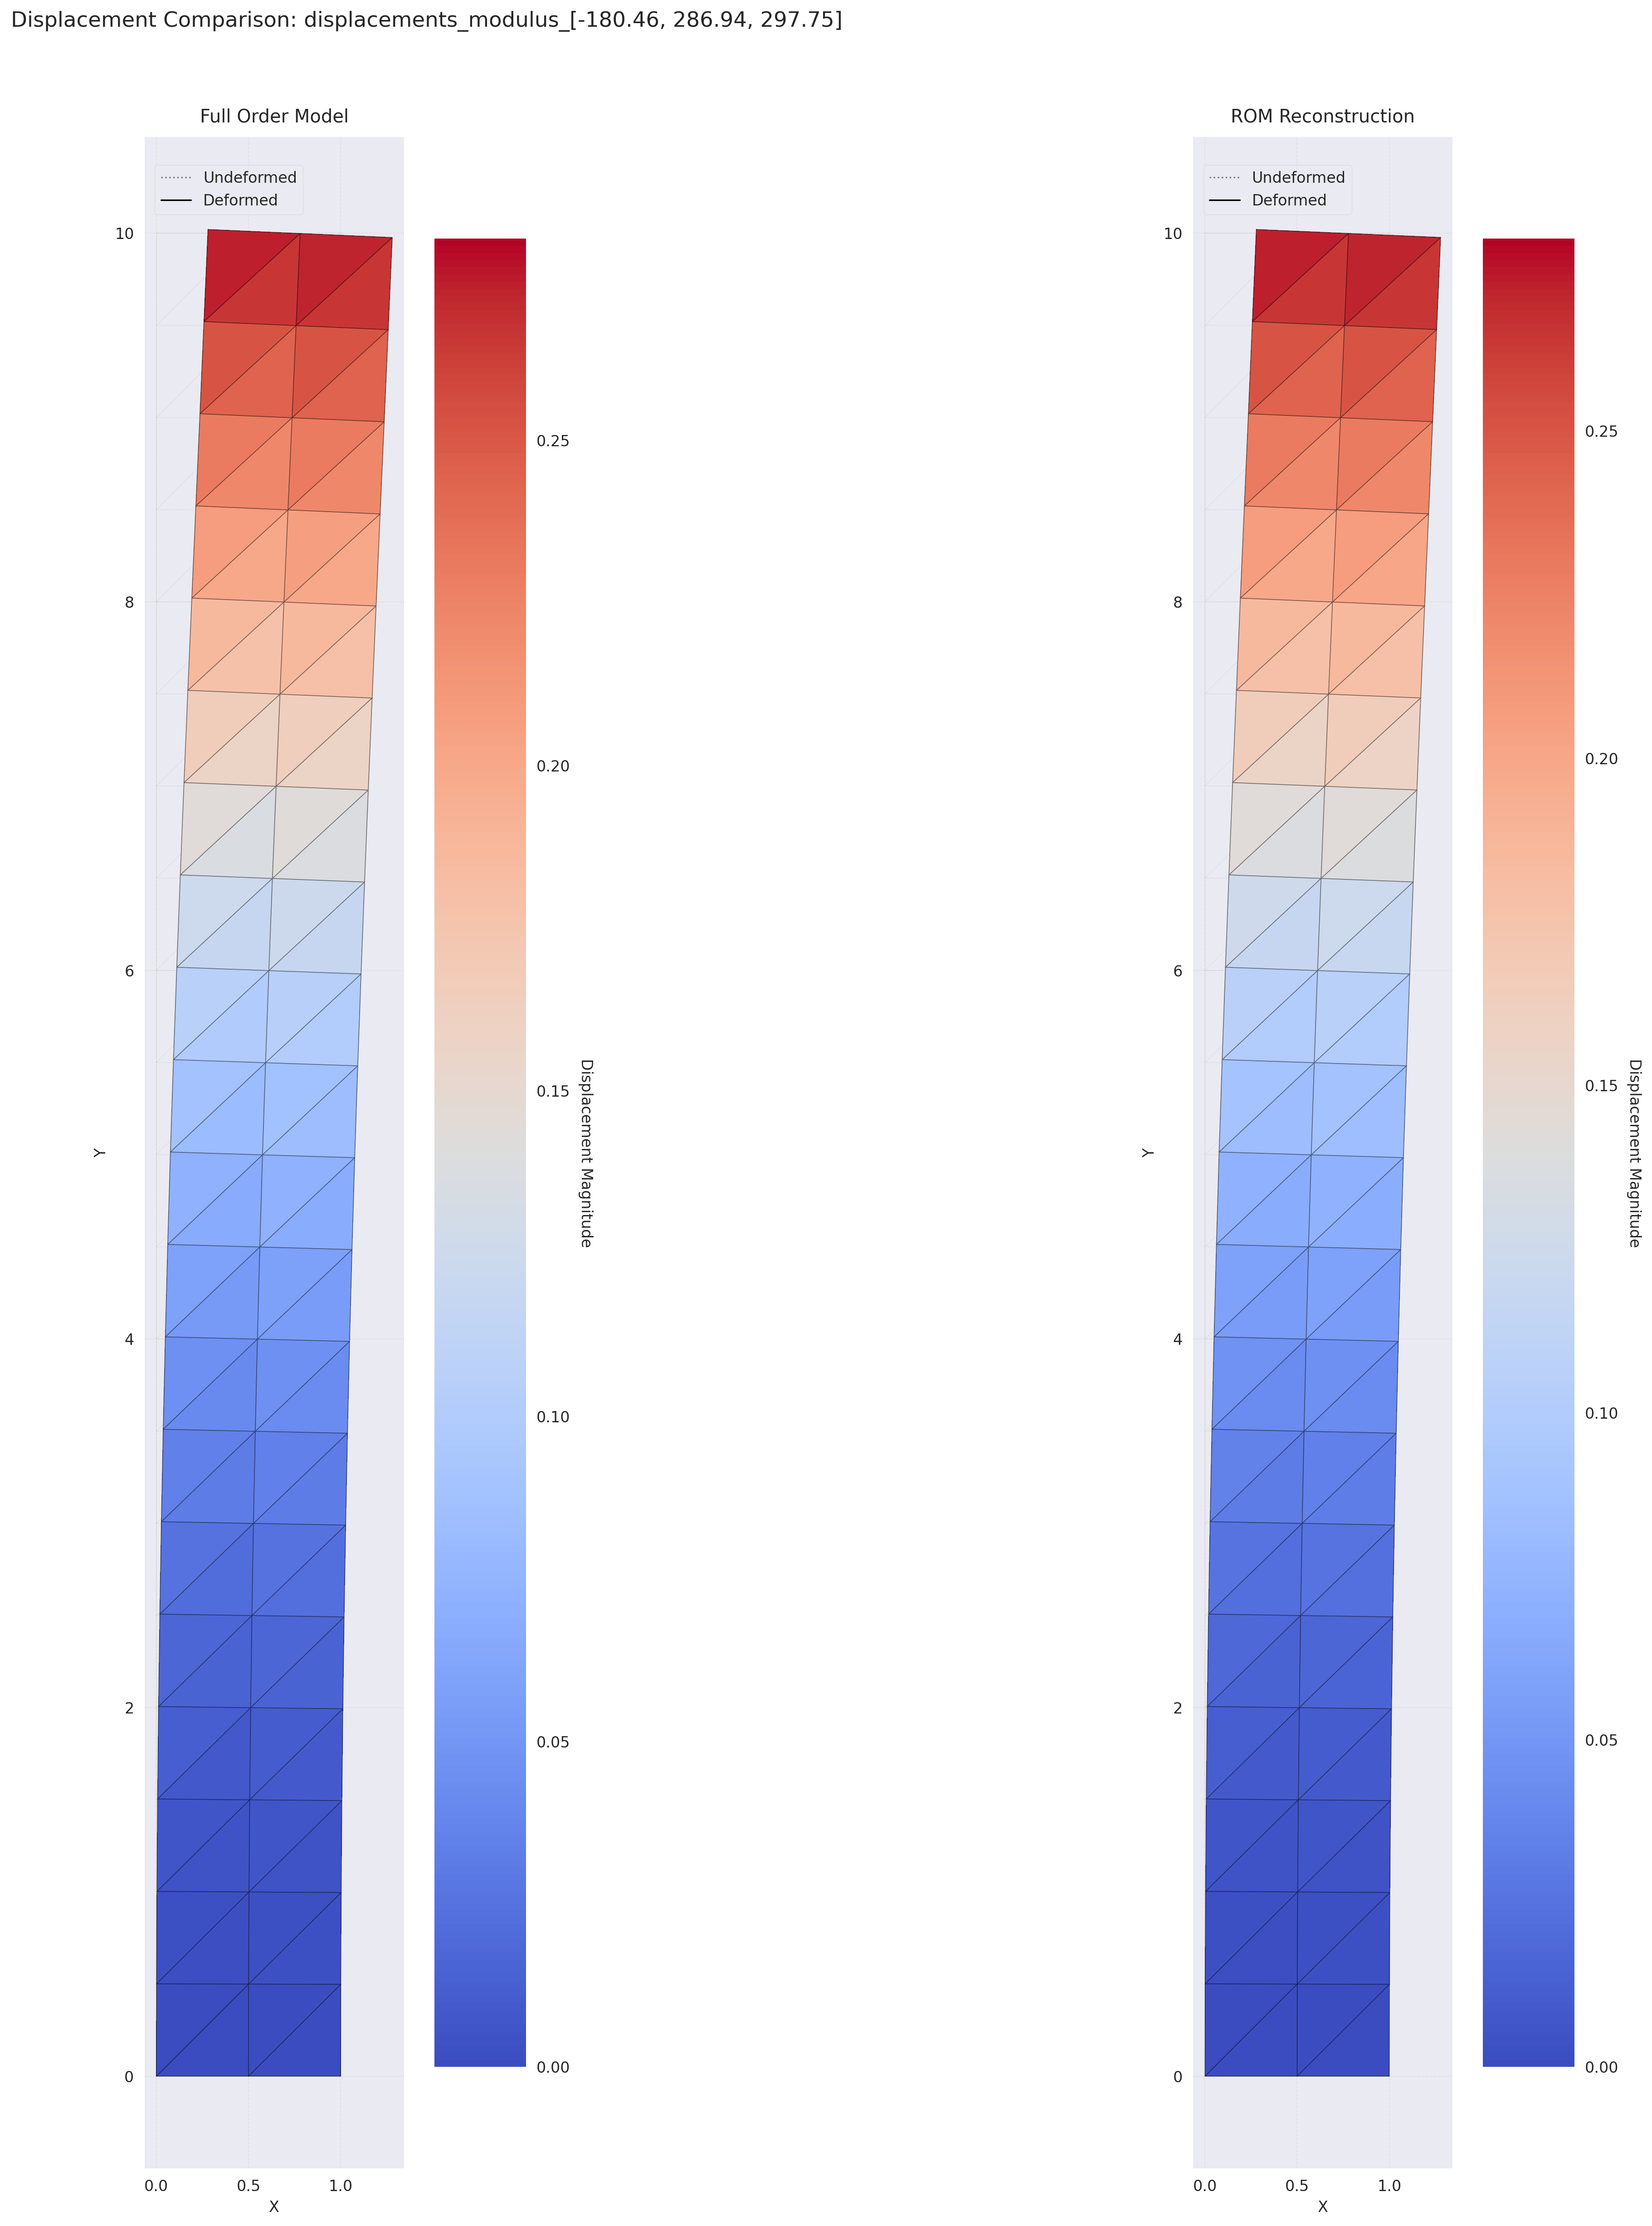


Comparison Metrics:
Max difference: 1.65e-03
Mean difference: 4.93e-04
Relative error: 0.48%

Processing case: displacements_modulus_[-279.08, -86.53, 377.93]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[-279.08_-86.53_377.93]\displacement_comparison_displacements_modulus_[-279.08, -86.53, 377.93].png


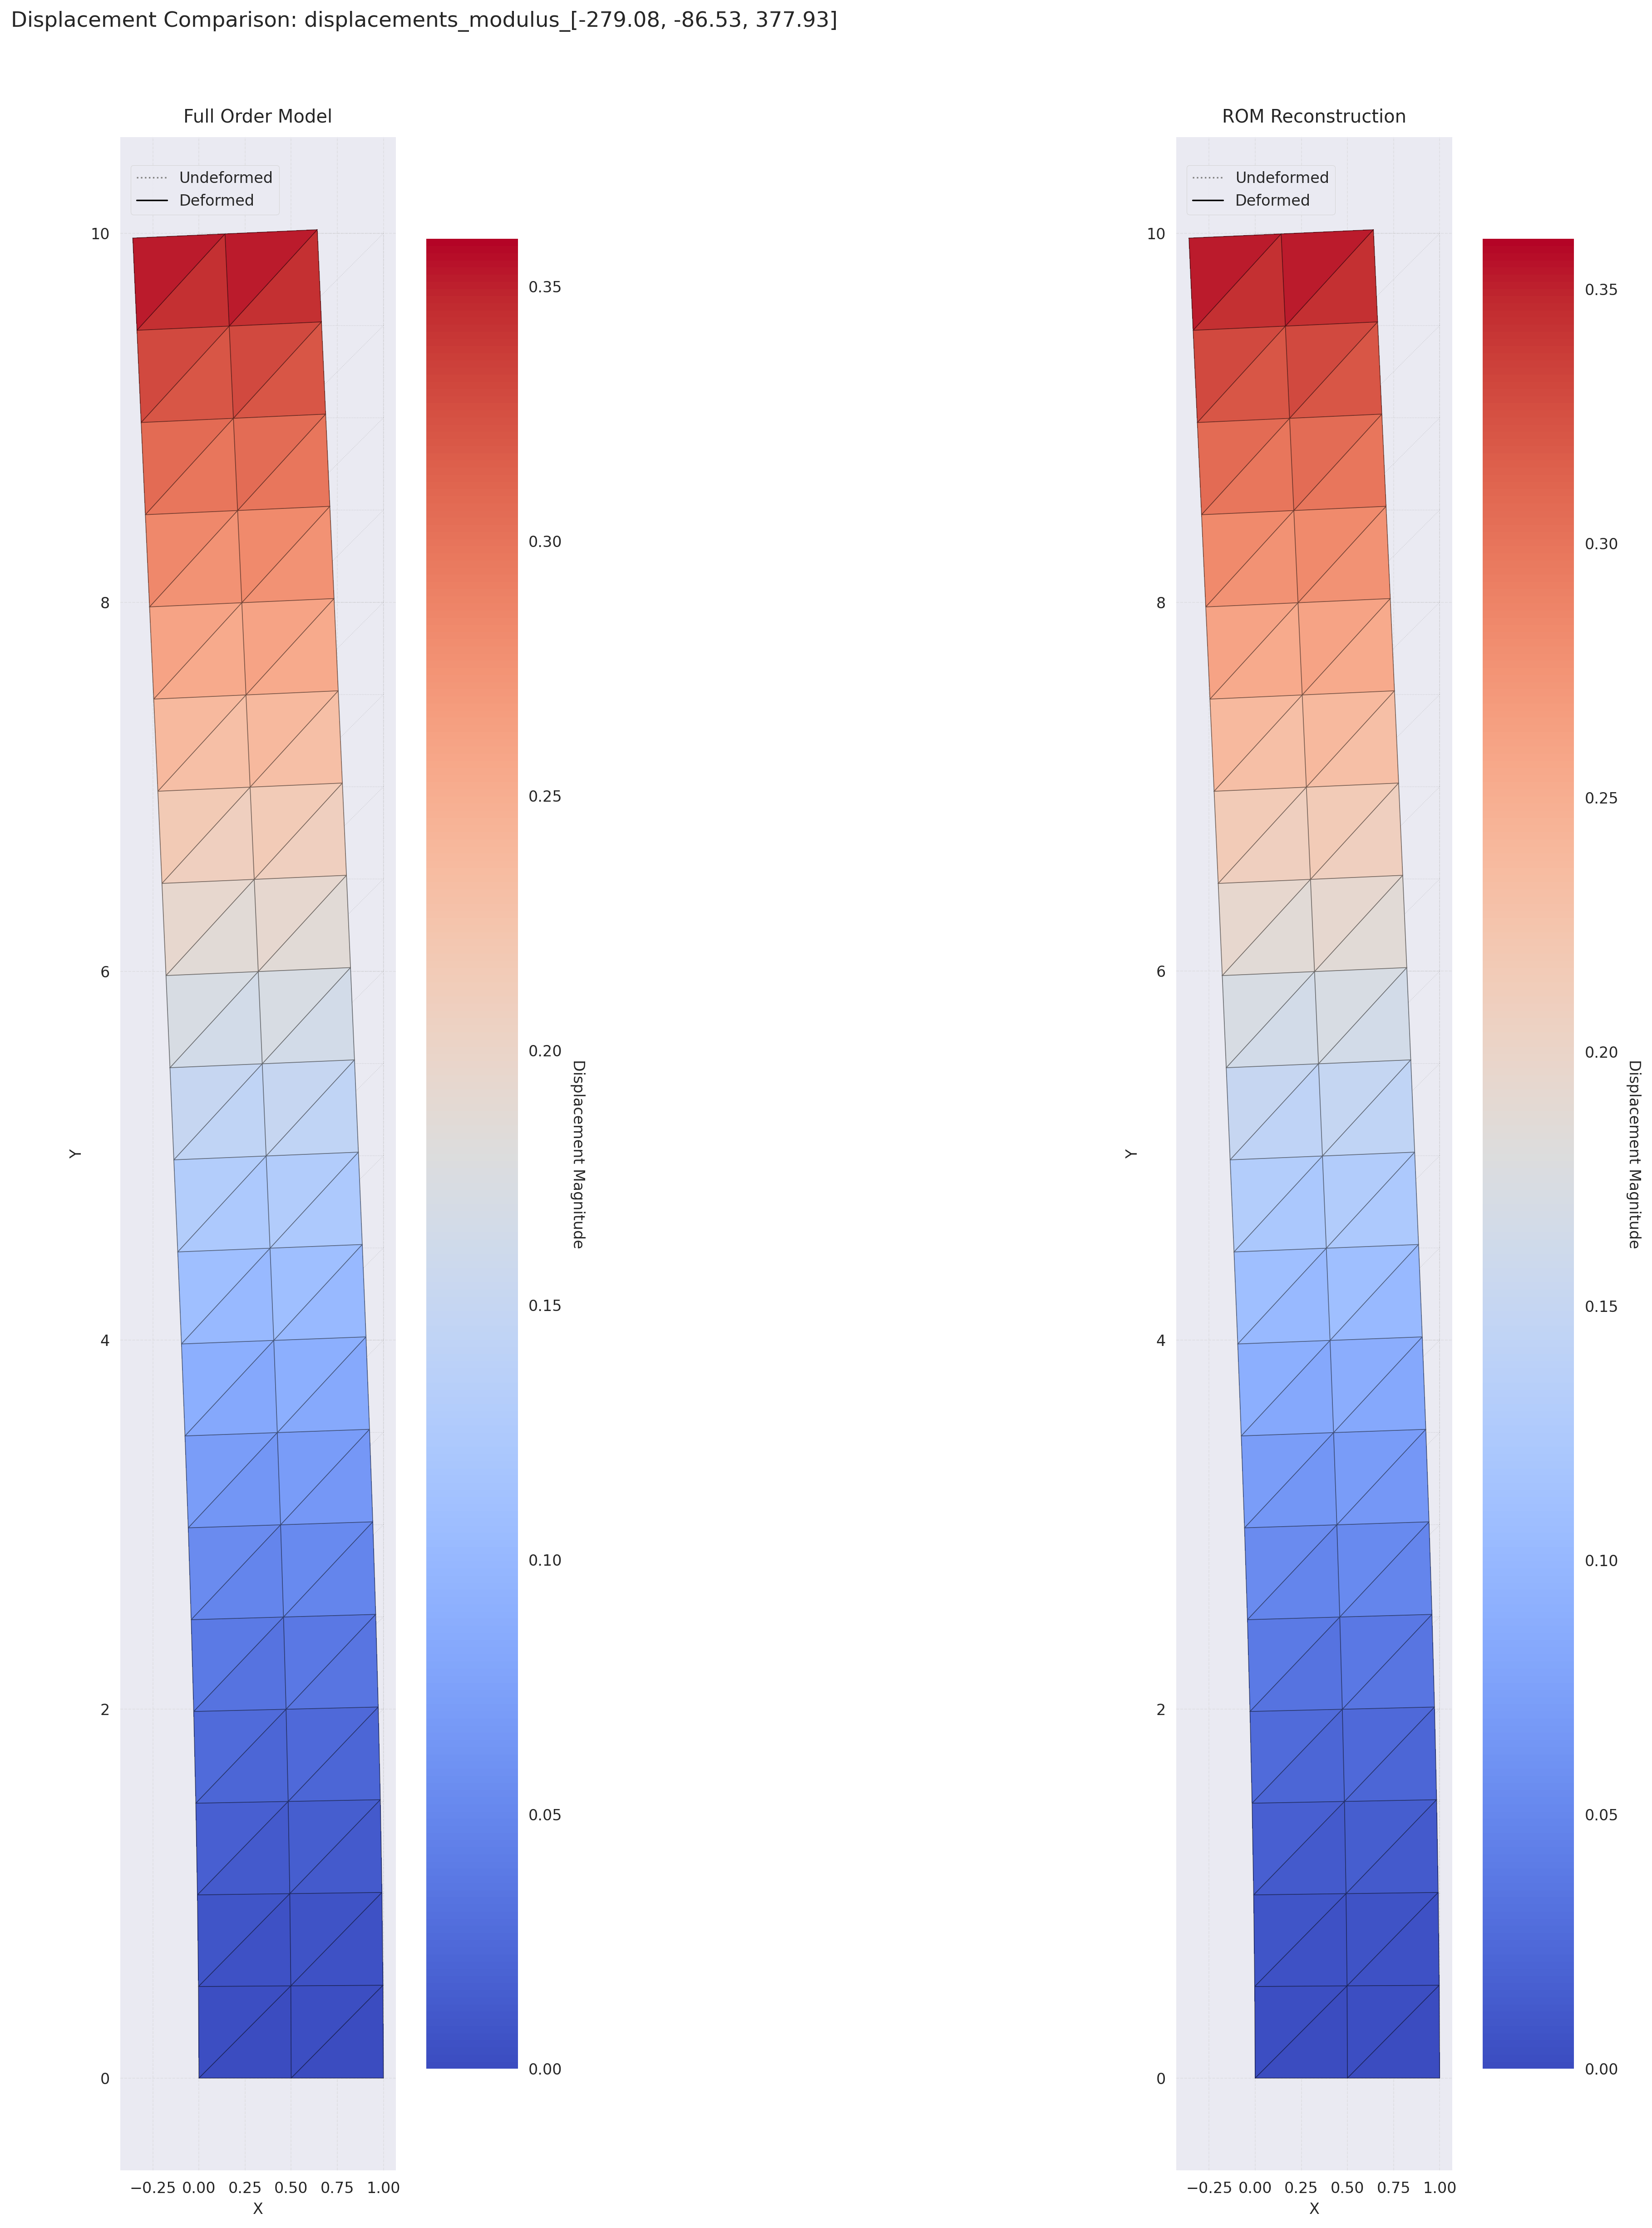


Comparison Metrics:
Max difference: 5.81e-04
Mean difference: 2.04e-04
Relative error: 0.14%

Processing case: displacements_modulus_[-297.61, -288.84, -265.5]
No matching ROM results found for displacements_modulus_[-297.61, -288.84, -265.5]

Processing case: displacements_modulus_[-66.39, -14.23, -19.61]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[-66.39_-14.23_-19.61]\displacement_comparison_displacements_modulus_[-66.39, -14.23, -19.61].png


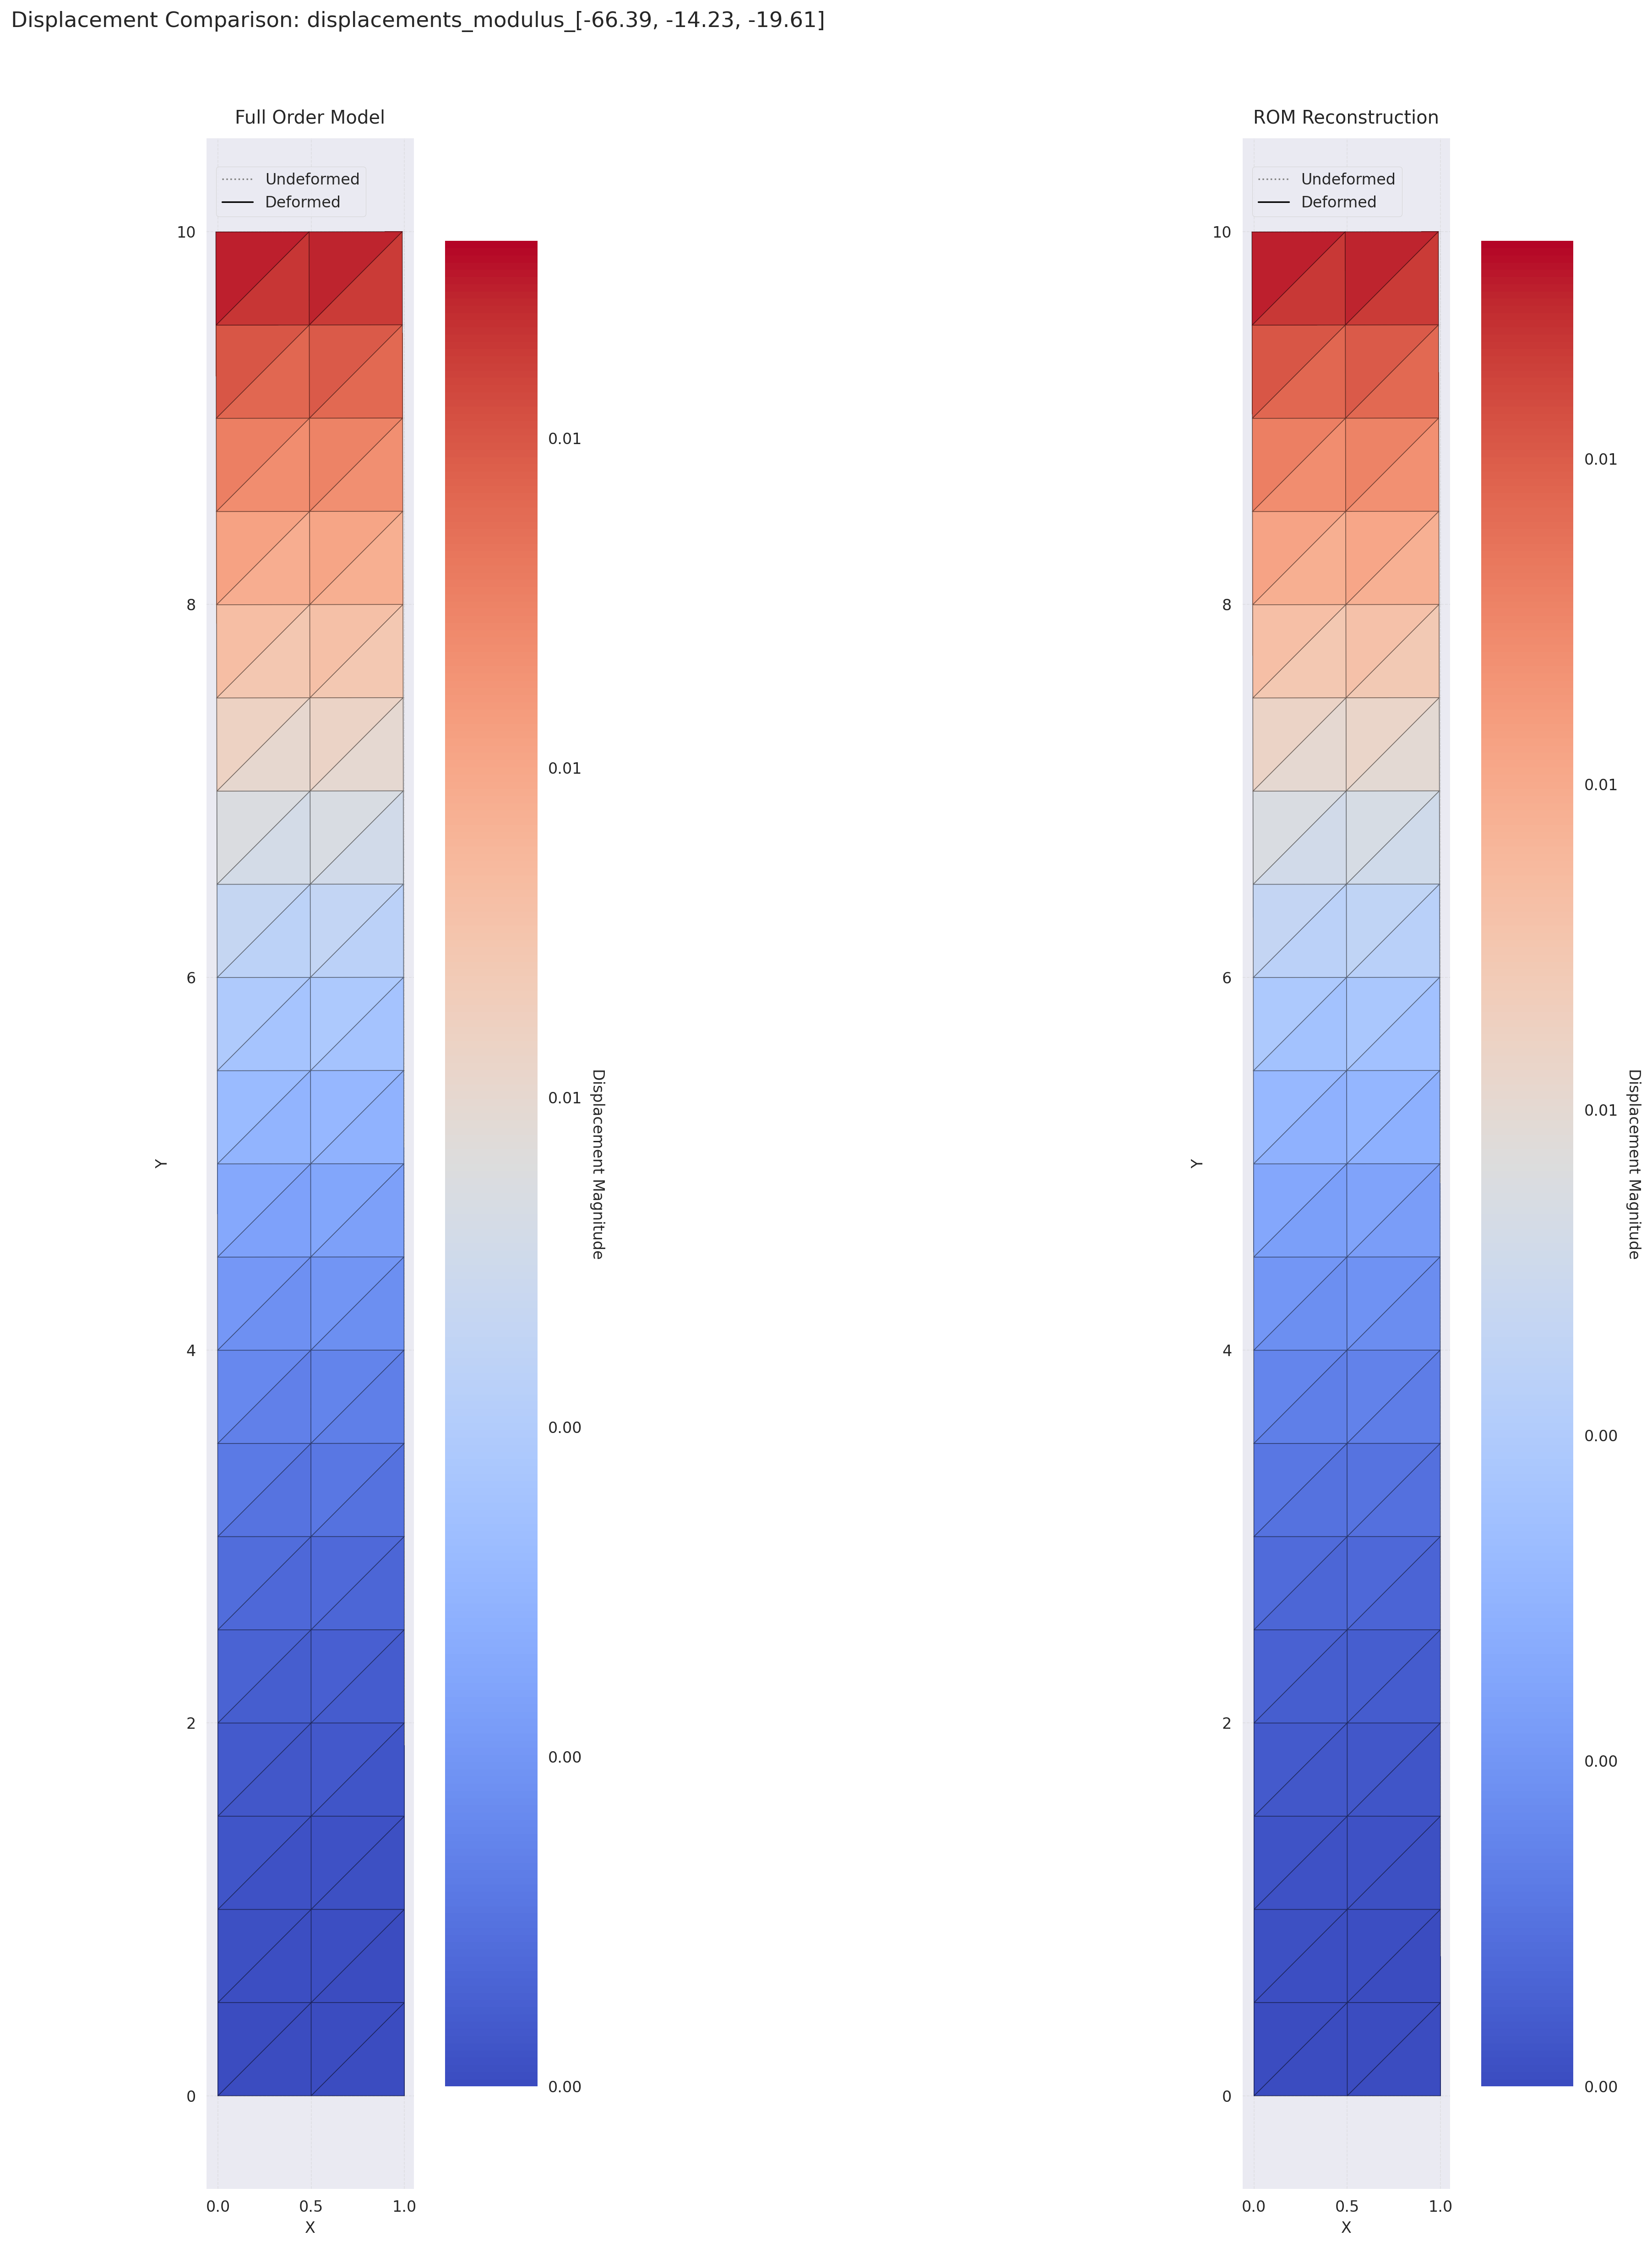


Comparison Metrics:
Max difference: 1.48e-04
Mean difference: 4.52e-05
Relative error: 1.17%

Processing case: displacements_modulus_[167.6, -199.89, 144.44]
No matching ROM results found for displacements_modulus_[167.6, -199.89, 144.44]

Processing case: displacements_modulus_[219.28, -182.67, 96.25]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[219.28_-182.67_96.25]\displacement_comparison_displacements_modulus_[219.28, -182.67, 96.25].png


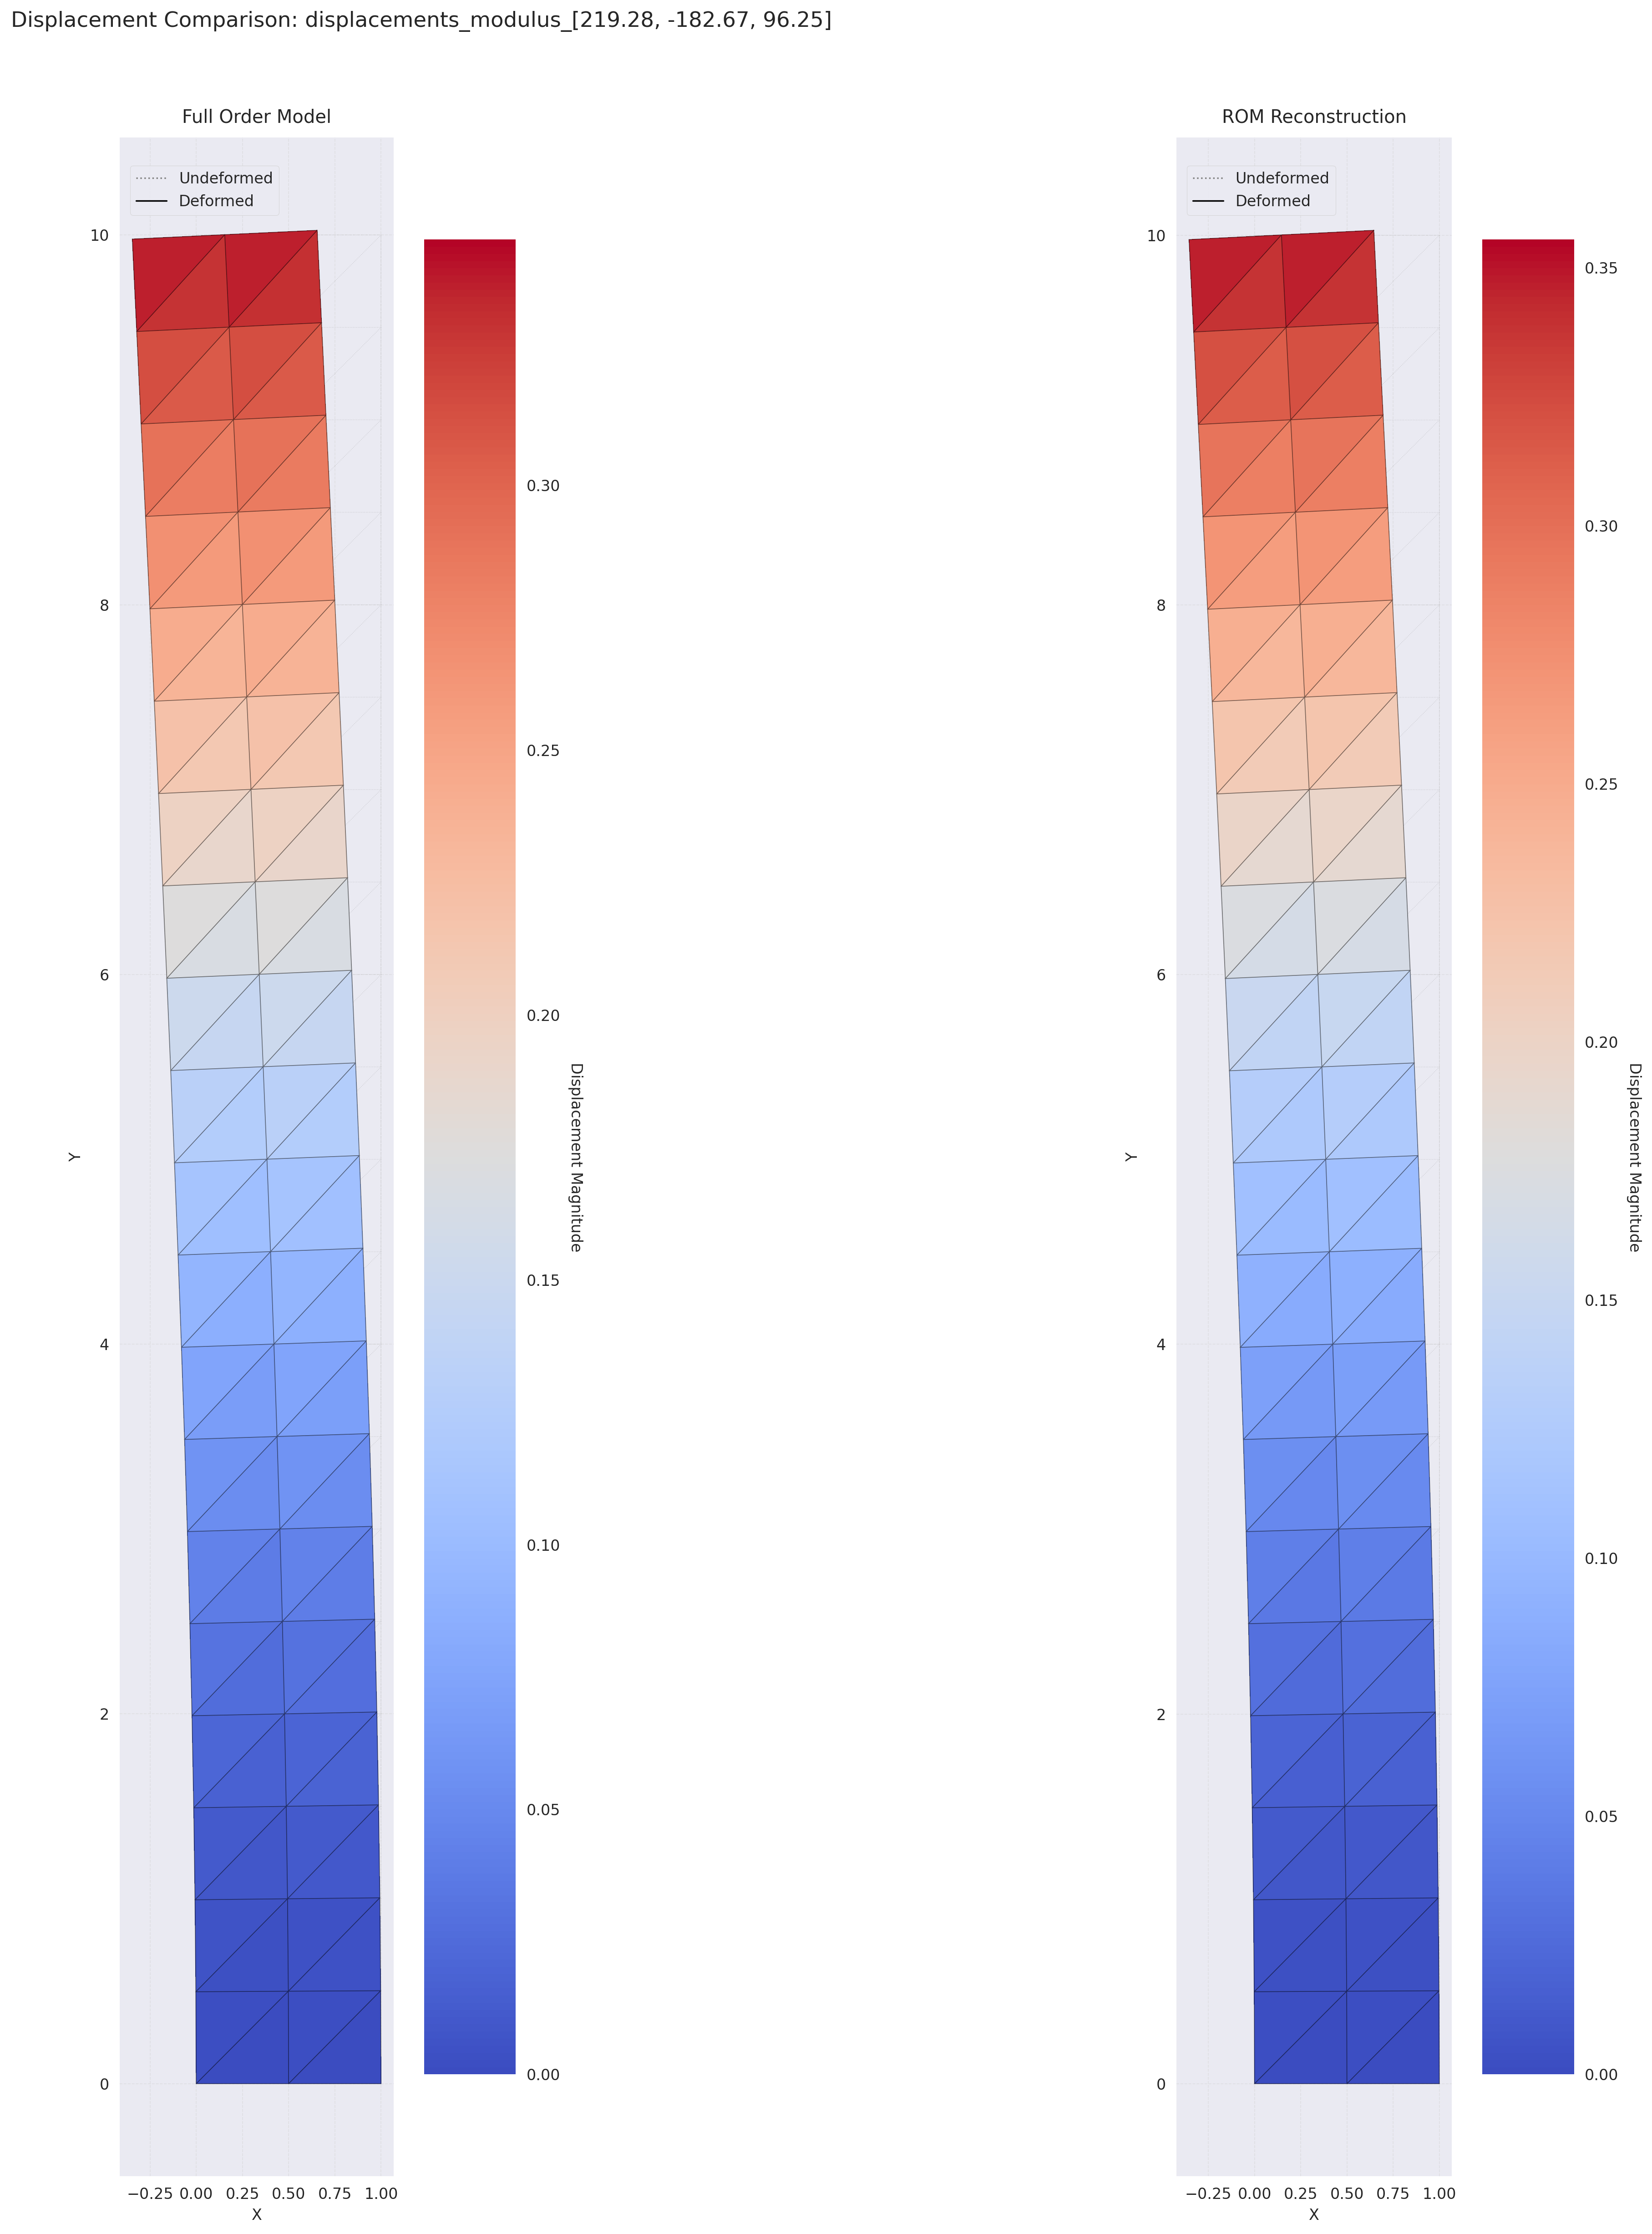


Comparison Metrics:
Max difference: 9.10e-03
Mean difference: 2.65e-03
Relative error: 1.92%

Processing case: displacements_modulus_[289.31, 144.02, 295.93]
Saved plot to: d:\Git_clone\Thesis_Cleaned\2D_beam_point_loading\Kratos_Results\ROM_Results\case_[289.31_144.02_295.93]\displacement_comparison_displacements_modulus_[289.31, 144.02, 295.93].png


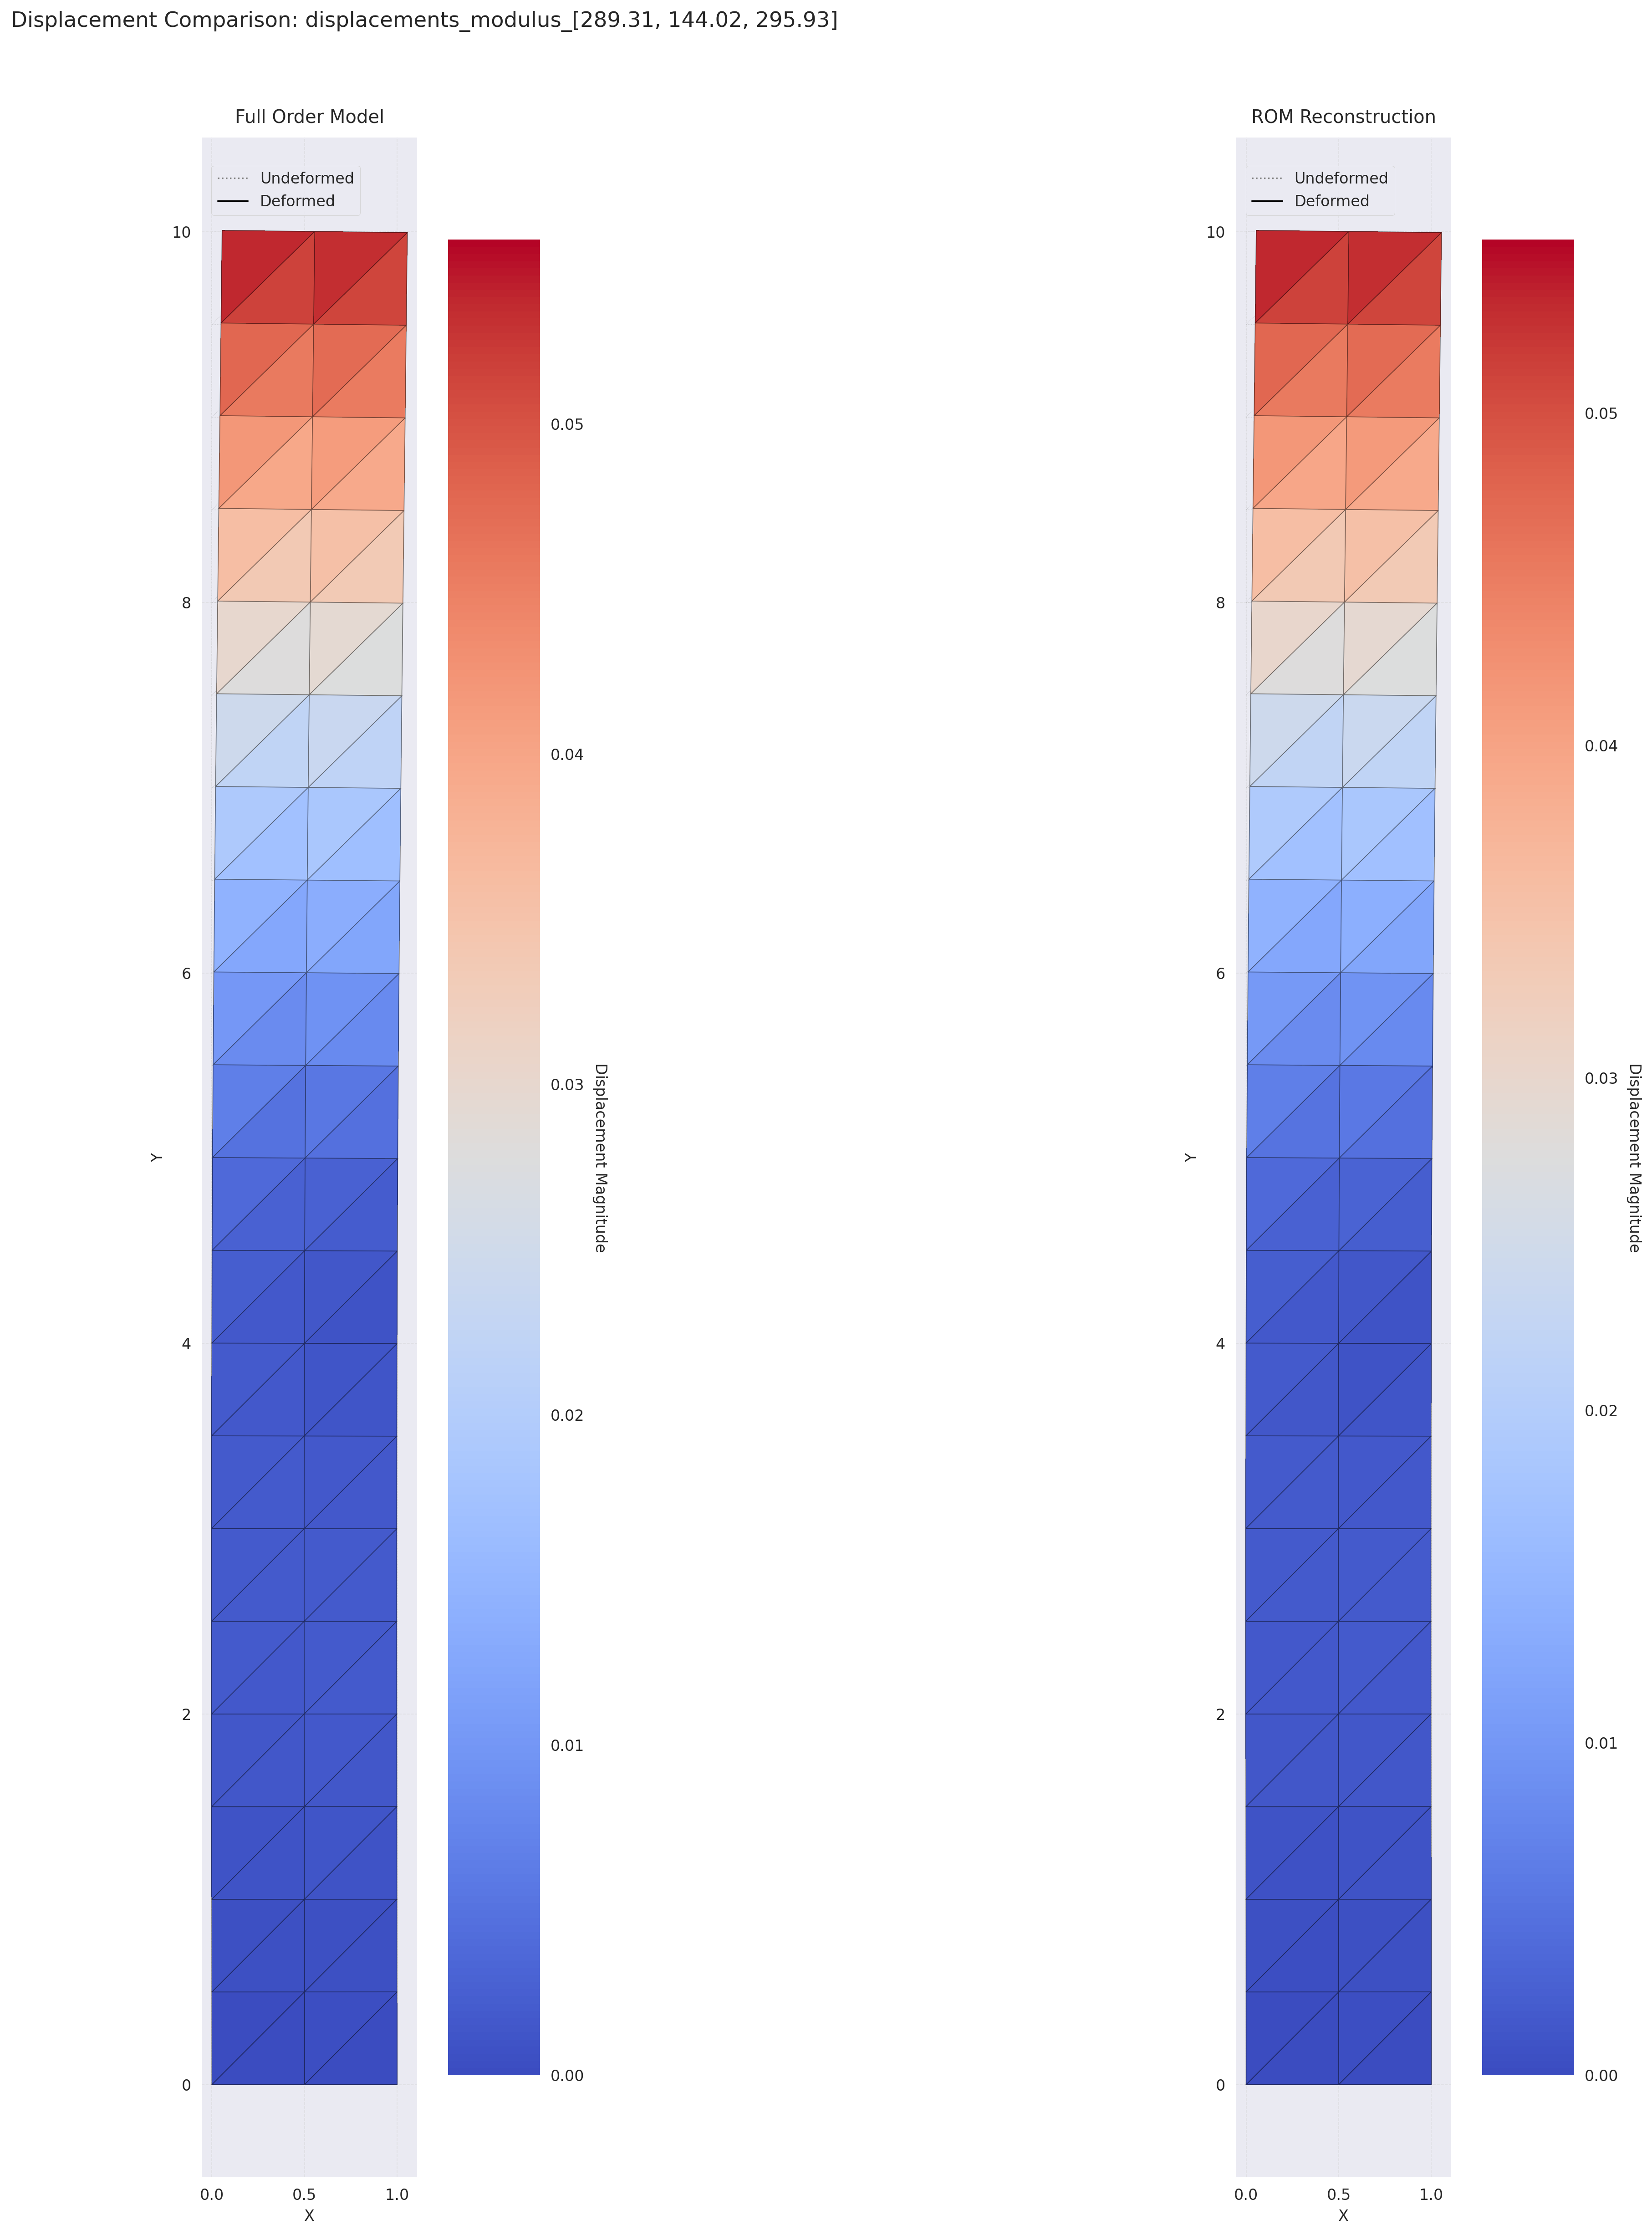


Comparison Metrics:
Max difference: 3.81e-04
Mean difference: 1.17e-04
Relative error: 0.78%

Processing case: displacements_modulus_[351.53, 221.2, 175.02]
No matching ROM results found for displacements_modulus_[351.53, 221.2, 175.02]


In [12]:
# Configure global plot settings
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.alpha'] = 0.5

def read_mdpa(mdpa_file):
    """Robust mdpa file reader that dynamically gets node count"""
    nodes = []
    elements = []
    sections = {'nodes': False, 'elements': False}
    
    with open(mdpa_file, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
                
            # Section detection
            if "Begin Nodes" in line:
                sections['nodes'] = True
                continue
            elif "End Nodes" in line:
                sections['nodes'] = False
                continue
            elif "Begin Elements" in line and "SmallDisplacementElement2D3N" in line:
                sections['elements'] = True
                continue
            elif "End Elements" in line:
                sections['elements'] = False
                continue
                
            # Data parsing
            parts = [p for p in line.split() if p]
            if sections['nodes'] and len(parts) >= 4:
                try:
                    nodes.append([float(parts[1]), float(parts[2])])
                except (ValueError, IndexError):
                    continue
            elif sections['elements'] and len(parts) >= 5:
                try:
                    elements.append([int(parts[2])-1, int(parts[3])-1, int(parts[4])-1])
                except (ValueError, IndexError):
                    continue
    
    nodes = np.array(nodes)
    elements = np.array(elements)
    num_nodes = len(nodes)
    
    print(f"Mesh information: {num_nodes} nodes, {len(elements)} elements")
    return nodes, elements

def extract_case_parameters(filename):
    """Flexible parameter extraction from filenames"""
    try:
        match = re.search(r'\[([-0-9., _]+)\]', filename)
        if match:
            param_str = match.group(1).replace('_', ',')
            return [float(x.strip()) for x in param_str.split(',')]
    except:
        return None
    return None

def find_matching_rom_case(fom_file, rom_root):
    """Advanced case matching with multiple patterns"""
    params = extract_case_parameters(os.path.basename(fom_file))
    if not params or len(params) != 3:
        return None
        
    patterns = [
        f"case_[{'_'.join([f'{p:.2f}' for p in params])}]*",
        f"case_[{','.join([f'{p:.2f}' for p in params])}]*",
        f"case_*{params[0]:.2f}*{params[1]:.2f}*{params[2]:.2f}*"
    ]
    
    for pattern in patterns:
        matches = glob.glob(os.path.join(rom_root, pattern))
        if matches:
            return matches[0]
    return None

def prepare_displacement_data(disp_array, expected_nodes):
    """Universal displacement data preparer that handles any node count"""
    disp_array = np.squeeze(disp_array)
    
    if disp_array.ndim == 1:  # ROM data (2*num_nodes,)
        if len(disp_array) == 2 * expected_nodes:
            return disp_array.reshape(expected_nodes, 2)
        else:
            raise ValueError(f"ROM data length {len(disp_array)} doesn't match 2*{expected_nodes}")
    elif disp_array.ndim == 2:  # FOM data (num_nodes,3) or (num_nodes,2)
        if disp_array.shape[0] == expected_nodes:
            return disp_array[:, :2]  # Use only X,Y components
        else:
            raise ValueError(f"FOM data shape {disp_array.shape} doesn't match {expected_nodes} nodes")
    else:
        raise ValueError(f"Unexpected array shape {disp_array.shape}")

def create_displacement_plot(ax, nodes, elements, displacements, title):
    """
    Create a displacement plot with a color map and improved visualization style
    with fixed legend positioning
    """
    # Create triangulations
    triang_undeformed = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)
    deformed = nodes + displacements
    triang_deformed = tri.Triangulation(deformed[:, 0], deformed[:, 1], elements)
    magnitude = np.linalg.norm(displacements, axis=1)

    # Normalization for color mapping
    vmax = np.percentile(magnitude, 99) if len(magnitude) > 0 else 1
    vmin = 0

    # Plot undeformed mesh with a light gray hatch style
    ax.triplot(triang_undeformed, color='gray', linewidth=0.4, alpha=0.3, linestyle='dotted', zorder=1)

    # Plot deformed mesh with displacement magnitude contour
    tcf = ax.tripcolor(triang_deformed, magnitude, shading='flat', cmap='coolwarm',
                        norm=Normalize(vmin=vmin, vmax=vmax), zorder=2)
    
    ax.triplot(triang_deformed, color='black', linewidth=0.5, alpha=0.5, zorder=3)

    # Add colorbar with improved format
    cbar = plt.colorbar(tcf, ax=ax, format='%.2f', shrink=0.9, pad=0.02)
    cbar.set_label('Displacement Magnitude', rotation=270, labelpad=15)

    # Configure axes for better readability
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_aspect('equal')

    # Add legend manually for undeformed and deformed shapes
    # FIXED: Better legend positioning and sizing
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', linestyle='dotted', lw=1, label='Undeformed'),
        Line2D([0], [0], color='black', lw=1, label='Deformed')
    ]
    # Move legend to upper left with more space and better visibility
    leg = ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
                   frameon=True, framealpha=0.9, edgecolor='lightgray',
                   bbox_to_anchor=(0.01, 0.99))
    
    # Make sure the legend text is readable
    for text in leg.get_texts():
        text.set_fontweight('normal')

    return tcf

def save_comparison_plot(fig, rom_case_dir, case_name):
    """Save plot to ROM results directory"""
    if not os.path.exists(rom_case_dir):
        os.makedirs(rom_case_dir)
    
    plot_path = os.path.join(rom_case_dir, f"displacement_comparison_{case_name}.png")
    fig.savefig(plot_path, dpi=300, bbox_inches='tight', pad_inches=0.2)
    print(f"Saved plot to: {plot_path}")

def compare_fom_rom(mdpa_file, fom_path, rom_root, scale_factor=1e5):
    """Main comparison workflow that handles any mesh size"""
    try:
        # Read mesh data and get dynamic node count
        nodes, elements = read_mdpa(mdpa_file)
        num_nodes = len(nodes)
        
        fom_files = sorted(glob.glob(os.path.join(fom_path, "displacements_modulus_*.npy")))
        if not fom_files:
            print(f"No FOM files found in {fom_path}")
            return

        for fom_file in fom_files:
            case_name = os.path.basename(fom_file)[:-4]
            print(f"\nProcessing case: {case_name}")
            
            try:
                # Load and prepare FOM data
                fom_disp = np.load(fom_file)
                fom_disp_2d = prepare_displacement_data(fom_disp, num_nodes) * scale_factor
                
                # Find matching ROM case
                rom_case_dir = find_matching_rom_case(fom_file, rom_root)
                rom_file = os.path.join(rom_case_dir, "results", "u_full.npy") if rom_case_dir else None
                
                if not rom_case_dir or not os.path.exists(rom_file):
                    print(f"No matching ROM results found for {case_name}")
                    
                    # Plot just FOM results
                    fig, ax = plt.subplots(figsize=(9, 8), dpi=120)
                    create_displacement_plot(ax, nodes, elements, fom_disp_2d, 
                                           f"FOM: {case_name}")
                    plt.tight_layout()
                    
                    if rom_case_dir:
                        save_comparison_plot(fig, rom_case_dir, case_name)
                    plt.close(fig)
                    continue
                    
                # Load and prepare ROM data
                rom_disp = np.load(rom_file)
                rom_disp_2d = prepare_displacement_data(rom_disp, num_nodes) * scale_factor
                
                # Create comparison figure
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 20), dpi=240)
                fig.suptitle(f"Displacement Comparison: {case_name}", fontsize=14, y=1.02)
                
                create_displacement_plot(ax1, nodes, elements, fom_disp_2d, "Full Order Model")
                create_displacement_plot(ax2, nodes, elements, rom_disp_2d, "ROM Reconstruction")
                
                plt.tight_layout()
                save_comparison_plot(fig, rom_case_dir, case_name)
                plt.show()
                plt.close(fig)
                
                # Calculate comparison metrics
                diff = np.linalg.norm(fom_disp_2d - rom_disp_2d, axis=1)
                fom_mag = np.linalg.norm(fom_disp_2d, axis=1)
                
                print("\nComparison Metrics:")
                print(f"Max difference: {np.max(diff):.2e}")
                print(f"Mean difference: {np.mean(diff):.2e}")
                print(f"Relative error: {100*np.mean(diff)/np.mean(fom_mag):.2f}%")
                
            except Exception as e:
                print(f"Error processing {case_name}: {str(e)}")
                continue

    except Exception as e:
        print(f"Error in main workflow: {str(e)}")

# Execute the analysis
if __name__ == "__main__":
    cwd = os.getcwd()
    mdpa_files = glob.glob(os.path.join(cwd, "*.mdpa"))
    
    if not mdpa_files:
        print("No .mdpa file found in current directory")
    else:
        compare_fom_rom(
            mdpa_file=mdpa_files[0],
            fom_path=DISPLACEMENT_PATH,
            rom_root=os.path.join(cwd, "Kratos_Results", "ROM_Results"),
            scale_factor=2e5  # Adjust based on your data scale
        )